# Scenario
Create a model that will predict whether a airbnb will get a perfect 5.0 rating in San Diego California. The purpose of this model is for airbnb hosts to have a way to evaluate their rentals and make sure that they are meeting all of the criteria to get that perfect review.

## Alternative Scenario: 
    - Airbnb is an industry disruptor. Many Hosts get a good deal of income from it. 
    - The goal of is to be a "5 Star Host" or "SuperHost". 
    - What can they do to get more 5 Star Ratings?
    - any particular features?

## Questions to Answer

1. How many units have a perfect rating?
2. How long have they had perfect rating?
3. How many reviews should the unit have to be considered? (ie, one 5.0 isn't enough)
4. What review metrics have the most impact?
5. What house factors have the most impact?
6. Relationship between price and rating?

## Loading Data

In [386]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.pylab import rcParams
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier
import numpy as np


In [387]:
pd.set_option('display.max_rows', 1000)
plt.style.use('fivethirtyeight')

In [388]:
#reviews_df = pd.read_csv('reviews.csv.gz')

In [389]:
#reviews_df.head()

## Listing_DF: Baseline DF with many columns

In [390]:
listing_df = pd.read_csv('listings.csv.gz')

In [391]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10935 non-null  int64  
 1   listing_url                                   10935 non-null  object 
 2   scrape_id                                     10935 non-null  int64  
 3   last_scraped                                  10935 non-null  object 
 4   name                                          10935 non-null  object 
 5   description                                   10809 non-null  object 
 6   neighborhood_overview                         7440 non-null   object 
 7   picture_url                                   10935 non-null  object 
 8   host_id                                       10935 non-null  int64  
 9   host_url                                      10935 non-null 

In [392]:
listing_df['price']

0         $60.00
1        $282.00
2        $348.00
3        $368.00
4        $264.00
          ...   
10930    $228.00
10931    $168.00
10932    $500.00
10933     $67.00
10934     $88.00
Name: price, Length: 10935, dtype: object

### Fixing Price

In [393]:
listing_df['price'] = listing_df['price'].map(lambda x: x.replace('$',' '))
listing_df['price'] = listing_df['price'].map(lambda x: x.replace(',',''))
listing_df['price'] = listing_df['price'].astype(float)

In [394]:
listing_df['price']

0         60.0
1        282.0
2        348.0
3        368.0
4        264.0
         ...  
10930    228.0
10931    168.0
10932    500.0
10933     67.0
10934     88.0
Name: price, Length: 10935, dtype: float64

## Review Score DF

In [395]:
#review_score_df = listing_df[['id', 'price', 'review_scores_rating', 'review_scores_accuracy',
#                             'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
#                             'review_scores_location', 'review_scores_value', 'number_of_reviews',
#                             'number_of_reviews_ltm', 'number_of_reviews_l30d']]

In [396]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10935 non-null  int64  
 1   listing_url                                   10935 non-null  object 
 2   scrape_id                                     10935 non-null  int64  
 3   last_scraped                                  10935 non-null  object 
 4   name                                          10935 non-null  object 
 5   description                                   10809 non-null  object 
 6   neighborhood_overview                         7440 non-null   object 
 7   picture_url                                   10935 non-null  object 
 8   host_id                                       10935 non-null  int64  
 9   host_url                                      10935 non-null 

In [397]:
review_score_df = listing_df[['price', 'review_scores_rating', 'review_scores_accuracy',
                             'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                             'review_scores_location', 'review_scores_value','accommodates',
                              'bedrooms', 'beds', 'instant_bookable',
                             'property_type', 'room_type', 'amenities', 'availability_365', 'availability_30',
                             'availability_90',
                             'host_id', 'calculated_host_listings_count', 'host_response_time', 'host_response_rate',
                             'host_is_superhost']]

In [398]:
df = review_score_df

In [399]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           10935 non-null  float64
 1   review_scores_rating            9408 non-null   float64
 2   review_scores_accuracy          9385 non-null   float64
 3   review_scores_cleanliness       9385 non-null   float64
 4   review_scores_checkin           9383 non-null   float64
 5   review_scores_communication     9385 non-null   float64
 6   review_scores_location          9383 non-null   float64
 7   review_scores_value             9383 non-null   float64
 8   accommodates                    10935 non-null  int64  
 9   bedrooms                        9905 non-null   float64
 10  beds                            10813 non-null  float64
 11  instant_bookable                10935 non-null  object 
 12  property_type                   

In [400]:
df['host_response_time'].value_counts()

within an hour        7911
within a few hours    1327
within a day           590
a few days or more     285
Name: host_response_time, dtype: int64

In [401]:
df['host_response_rate'].value_counts()

100%    7229
97%      354
98%      349
91%      279
99%      261
75%      182
90%      177
94%      128
0%       125
96%      106
92%       94
40%       85
93%       82
85%       68
80%       62
95%       61
88%       59
50%       39
70%       37
60%       31
83%       31
86%       29
89%       26
67%       24
84%       22
66%       19
35%       15
77%       15
78%       15
25%       14
87%       12
33%       12
68%       10
71%        8
20%        7
42%        6
81%        4
11%        4
74%        4
46%        3
43%        3
72%        2
82%        2
79%        2
13%        2
44%        2
26%        2
62%        1
14%        1
53%        1
63%        1
10%        1
27%        1
17%        1
69%        1
65%        1
73%        1
Name: host_response_rate, dtype: int64

In [402]:
df['availability_365'].value_counts()

0      861
365    194
364    151
358    150
81      82
360     72
361     71
356     68
1       62
82      62
89      60
51      59
90      58
20      57
355     57
362     56
50      51
52      51
80      50
359     50
363     49
357     49
63      48
326     47
352     47
57      46
234     45
329     44
49      43
351     43
203     43
344     43
295     41
296     41
346     41
75      41
83      41
79      40
353     40
327     40
3       40
72      40
275     39
173     39
65      39
84      39
69      39
340     38
87      38
110     38
70      37
85      37
77      37
66      37
220     37
88      37
180     37
266     36
265     36
336     36
349     36
235     36
60      36
2       36
324     36
270     36
78      35
74      35
328     35
56      35
64      35
179     34
33      34
354     34
35      34
53      34
67      34
73      33
30      33
58      33
59      33
126     33
141     33
36      33
44      33
142     33
323     32
163     32
309     32
325     32
341     32

In [403]:
df['availability_90'].value_counts()

0     1479
90     323
89     225
83     201
20     190
86     162
81     161
51     160
87     141
85     133
1      133
82     126
80     123
53     123
50     121
30     121
21     120
65     119
69     116
52     115
36     113
79     113
63     112
47     108
77     107
45     107
60     106
70     105
57     104
56     104
78     103
59     103
32     101
66     101
18     101
76     100
64     100
88      99
22      98
33      98
71      97
58      97
25      97
73      97
72      97
23      96
35      96
44      95
49      95
26      95
2       94
48      94
24      94
75      94
43      94
37      94
28      93
54      93
9       92
38      92
17      91
46      91
61      90
74      90
42      88
27      88
84      88
41      87
29      87
31      87
5       85
3       85
34      85
11      85
67      85
68      84
12      83
19      83
7       83
14      81
16      81
39      81
4       80
40      80
10      78
13      77
55      77
62      74
8       73
15      73
6       64

In [404]:
df['availability_30'].value_counts()

0     2939
5      450
1      447
2      434
4      432
3      400
30     394
6      383
8      333
9      308
7      297
29     275
11     259
10     258
23     244
13     240
12     239
21     238
14     218
16     208
15     206
20     202
26     193
19     192
17     191
18     187
27     180
22     163
25     158
28     141
24     126
Name: availability_30, dtype: int64

### Analysis of Availability
- 2939 (26.8% of units) have no availability a month out.
- 1479 (13.5% of units) have no availability 3 months out.
- 

- 5102 (46.7%) have 5 or less days available for the month ahead.

In [405]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           10935 non-null  float64
 1   review_scores_rating            9408 non-null   float64
 2   review_scores_accuracy          9385 non-null   float64
 3   review_scores_cleanliness       9385 non-null   float64
 4   review_scores_checkin           9383 non-null   float64
 5   review_scores_communication     9385 non-null   float64
 6   review_scores_location          9383 non-null   float64
 7   review_scores_value             9383 non-null   float64
 8   accommodates                    10935 non-null  int64  
 9   bedrooms                        9905 non-null   float64
 10  beds                            10813 non-null  float64
 11  instant_bookable                10935 non-null  object 
 12  property_type                   

In [406]:
df['instant_bookable'].value_counts()

f    5912
t    5023
Name: instant_bookable, dtype: int64

### Host Info

In [407]:
df['host_id'].value_counts()

88168913     219
429429981    163
3017970      119
226804666     85
147276739     76
            ... 
113819301      1
205127323      1
14767766       1
5039760        1
20667939       1
Name: host_id, Length: 5034, dtype: int64

In [408]:
df['calculated_host_listings_count'].value_counts()

1      3568
2      1468
3       816
4       540
5       410
7       280
6       222
219     219
8       216
163     163
13      156
19      152
9       144
10      140
119     119
39      117
14      112
27      108
15      105
31       93
85       85
21       84
12       84
42       84
76       76
25       75
37       74
73       73
23       69
17       68
68       68
11       66
22       66
65       65
62       62
61       61
58       58
29       58
28       56
55       55
51       51
48       48
16       48
47       47
20       40
36       36
18       36
35       35
33       33
26       26
Name: calculated_host_listings_count, dtype: int64

In [409]:
#df['host_listings_1-4'] = df['calculated_host_listings_count'] <= 4
#df['host_listings_3-4'] = df['calculated_host_listings_count'] == range(3 , 4)
df['host_listings_5+'] =df['calculated_host_listings_count'] >= 5

In [410]:
df['host_listings_5+'].value_counts()

False    6392
True     4543
Name: host_listings_5+, dtype: int64

In [411]:
#df.groupby('host_id').mean()

In [412]:
df['host_is_superhost'].value_counts()

f    6091
t    4840
Name: host_is_superhost, dtype: int64

### New Feature: Capacity Ranges

In [413]:
df['accommodates'].value_counts()

2     2716
4     2306
6     1638
8      841
3      757
5      647
1      604
10     411
7      291
12     224
16     172
9      123
14      99
11      53
15      30
13      20
0        3
Name: accommodates, dtype: int64

In [414]:
#df['capacity_0-2'] = df['accommodates'] <= 2

In [415]:
#df['capacity_3-4'] = df['accommodates'] == range(3-4)

In [416]:
#df['capacity_5-9'] = df['accommodates'] == range(5-9)
#df['capacity_10+'] = df['accommodates'] >= 10

In [417]:
#df['capacity_-2'] = df['accommodates'] <= 2
#df['capacity_-4'] = df['accommodates'] <= 4
#df['capacity_-6'] = df['accommodates'] <= 6
#df['capacity_-10'] = df['accommodates'] <= 10
#df['capacity_11+'] = df['accommodates'] >= 11


In [418]:
df['capacity_couple'] = df['accommodates'] <= 2
df['capacity_family'] = df['accommodates'] == range(3 , 4)
df['capacity_large'] = df['accommodates'] <= 5

In [419]:
df['capacity_family'].value_counts()

False    10178
True       757
Name: capacity_family, dtype: int64

### New Feature: Bedroom Ranges

In [420]:
df['bedrooms'].value_counts()

1.0     4621
2.0     2684
3.0     1538
4.0      665
5.0      254
6.0       87
7.0       25
8.0       16
10.0       6
9.0        5
11.0       2
12.0       2
Name: bedrooms, dtype: int64

In [421]:
#df['bedrooms_1'] = df['bedrooms'] == 1
#df['bedrooms_2'] = df['bedrooms'] == 2
#df['bedrooms_3'] = df['bedrooms'] == 3
#df['bedrooms_4+'] = df['bedrooms'] >= 4

In [422]:
df['bedrooms_1-2'] = df['bedrooms'] <= 2
df['bedrooms_3+'] = df['bedrooms'] >= 3

In [423]:
df['bedrooms_1-2'].value_counts()

True     7305
False    3630
Name: bedrooms_1-2, dtype: int64

### New Feature: Booked
- Booked: For the next 30 days, at least 25 days have already been booked.

In [424]:
df['booked'] = df['availability_30'] <= 3

In [425]:
df.head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,host_response_time,host_response_rate,host_is_superhost,host_listings_5+,capacity_couple,capacity_family,capacity_large,bedrooms_1-2,bedrooms_3+,booked
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,2,1.0,...,within an hour,100%,f,False,True,False,True,True,False,True
1,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,6,3.0,...,within an hour,100%,t,False,False,False,False,False,True,False
2,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,2,1.0,...,within an hour,100%,t,False,True,False,True,True,False,False
3,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,6,3.0,...,within an hour,100%,t,False,False,False,False,False,True,False
4,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,1.0,...,within a few hours,100%,t,True,False,False,True,True,False,False


In [426]:
df.drop(['availability_30', 'availability_90', 'availability_365'], axis=1, inplace=True)

In [427]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           10935 non-null  float64
 1   review_scores_rating            9408 non-null   float64
 2   review_scores_accuracy          9385 non-null   float64
 3   review_scores_cleanliness       9385 non-null   float64
 4   review_scores_checkin           9383 non-null   float64
 5   review_scores_communication     9385 non-null   float64
 6   review_scores_location          9383 non-null   float64
 7   review_scores_value             9383 non-null   float64
 8   accommodates                    10935 non-null  int64  
 9   bedrooms                        9905 non-null   float64
 10  beds                            10813 non-null  float64
 11  instant_bookable                10935 non-null  object 
 12  property_type                   

### New Feature: Host Response Rate 100

In [428]:
df['host_response_rate'] = df['host_response_rate'].str.replace('%', ' ')
df['host_response_rate']  = df['host_response_rate'].astype('float')
df['host_response_100'] = df['host_response_rate'] == 100.0
df['host_response_100'].value_counts()

True     7229
False    3706
Name: host_response_100, dtype: int64

### Fixing Host is Superhost

In [429]:
df['host_is_superhost'] = df['host_is_superhost'].str.replace('f', 'False')
df['host_is_superhost'] = df['host_is_superhost'].str.replace('t', 'True')
df['superhost_True'] = df['host_is_superhost'] == 'True'
df['superhost_True'].value_counts()

False    6095
True     4840
Name: superhost_True, dtype: int64

In [430]:
df['instant_bookable'] = df['instant_bookable'].str.replace('f', 'False')
df['instant_bookable'] = df['instant_bookable'].str.replace('t', 'True')
df['instant_bookable_True'] = df['instant_bookable'] == 'True'
df['instant_bookable_True'].value_counts()

False    5912
True     5023
Name: instant_bookable_True, dtype: int64

### Number of Units with a 5.0 Avg Rating

In [431]:
df['review_scores_rating'].value_counts()

5.00    2054
4.80     248
4.91     238
4.86     237
4.88     233
4.89     226
4.83     220
4.92     216
4.67     209
4.96     207
4.94     207
4.90     206
4.50     202
4.93     200
4.75     196
4.95     184
4.85     179
4.97     172
4.87     165
4.00     164
4.82     161
4.84     154
4.98     138
4.81     138
4.79     137
4.78     135
4.76     108
4.73     107
4.71     107
4.70     100
4.74      99
4.77      97
4.60      93
4.72      89
4.69      81
4.63      78
4.68      71
4.65      70
4.64      67
4.99      59
4.33      59
4.57      51
4.58      51
4.62      49
3.00      49
4.59      47
4.66      47
4.56      47
4.61      45
4.40      43
4.53      41
4.44      36
4.52      35
4.54      34
4.55      33
4.43      32
1.00      32
4.25      32
4.38      29
4.47      29
4.46      23
3.67      23
4.51      22
4.42      22
4.48      22
4.45      20
0.00      19
4.20      19
4.32      18
3.50      18
4.39      17
4.29      17
4.41      14
4.35      12
4.17      12
2.00      12
4.14      11

In [432]:
df['review_scores_rating'].isna().sum()

1527

There are 1527 Null records that need to be dealt with. If I drop them, I will lose 14% of my data.

In [433]:
nulls = df[df['review_scores_rating'].isna()]

In [434]:
nulls.head(3)

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,host_listings_5+,capacity_couple,capacity_family,capacity_large,bedrooms_1-2,bedrooms_3+,booked,host_response_100,superhost_True,instant_bookable_True
12,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,4.0,...,False,False,False,False,False,True,False,False,False,True
23,217.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1.0,...,True,False,False,True,True,False,False,False,False,True
70,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0,...,False,True,False,True,True,False,False,True,False,False


nulls appear to have no ratings. Let's drop them for now.

In [435]:
df = df.dropna()

In [436]:
df

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,host_listings_5+,capacity_couple,capacity_family,capacity_large,bedrooms_1-2,bedrooms_3+,booked,host_response_100,superhost_True,instant_bookable_True
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,2,1.0,...,False,True,False,True,True,False,True,True,False,True
1,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,6,3.0,...,False,False,False,False,False,True,False,True,True,False
2,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,2,1.0,...,False,True,False,True,True,False,False,True,True,True
3,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,6,3.0,...,False,False,False,False,False,True,False,True,True,True
4,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,1.0,...,True,False,False,True,True,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10929,531.0,4.89,4.89,5.00,5.00,4.89,5.00,4.78,14,5.0,...,False,False,False,False,False,True,False,True,False,False
10930,228.0,4.78,4.82,4.85,4.98,4.90,4.82,4.80,8,3.0,...,False,False,False,False,False,True,False,True,True,False
10931,168.0,4.89,4.94,4.89,4.93,4.94,4.92,4.90,8,3.0,...,False,False,False,False,False,True,False,True,True,False
10932,500.0,5.00,4.50,5.00,5.00,5.00,5.00,5.00,2,1.0,...,False,True,False,True,True,False,False,False,False,True


<b> 8385 Records are left after dropping null values </b>

### Creating Classifier Column

In [437]:
df['rating_5'] = df['review_scores_rating'] == 5.00
df['accuracy_5'] = df['review_scores_accuracy'] == 5.00
df['cleanliness_5'] = df['review_scores_cleanliness'] == 5.00
df['checkin_5'] = df['review_scores_checkin'] == 5.00
df['location_5'] = df['review_scores_location'] == 5.00
df['value_5'] = df['review_scores_value'] == 5.00
df['communication_5'] = df['review_scores_communication'] == 5.00

In [438]:
df['rating_5'].value_counts()

False    6077
True     1733
Name: rating_5, dtype: int64

### 5.0 Rating Analysis:
- Out of 8385 records:
-- 22.5% had a perfect rating
-- 77.5% did not have a perfect rating

### Future Work: Analyze how much more likely a 5.0 rated rental is to be successful than a non-5.0 rated rental

In [439]:
df['location_5'].value_counts()

False    5434
True     2376
Name: location_5, dtype: int64

### Creating Binned Price Categories

<b> It is difficult to analyze price because it is relative. A low priced home that sleeps 10 people still costs more than a high priced home that sleeps 2 </b>

In [440]:
df['price'].describe()

count     7810.000000
mean       294.637900
std        330.516177
min         10.000000
25%        120.000000
50%        197.000000
75%        352.750000
max      10000.000000
Name: price, dtype: float64

In [441]:
df['price_high'] = df['price'] >= 350
df['price_low'] = df['price'] <= 120

In [442]:
#df['price_high'] = df['price'] >= 200
#df['price_low'] = df['price'] < 200

In [443]:
df

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,instant_bookable_True,rating_5,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,communication_5,price_high,price_low
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,2,1.0,...,True,True,True,True,True,False,True,True,False,True
1,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,6,3.0,...,False,False,False,False,False,False,False,False,False,False
2,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,2,1.0,...,True,False,True,False,True,False,False,True,False,False
3,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,6,3.0,...,True,False,False,False,True,False,False,True,True,False
4,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,1.0,...,False,True,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10929,531.0,4.89,4.89,5.00,5.00,4.89,5.00,4.78,14,5.0,...,False,False,False,True,True,True,False,False,True,False
10930,228.0,4.78,4.82,4.85,4.98,4.90,4.82,4.80,8,3.0,...,False,False,False,False,False,False,False,False,False,False
10931,168.0,4.89,4.94,4.89,4.93,4.94,4.92,4.90,8,3.0,...,False,False,False,False,False,False,False,False,False,False
10932,500.0,5.00,4.50,5.00,5.00,5.00,5.00,5.00,2,1.0,...,True,True,False,True,True,True,True,True,True,False


### Checking # of reviews

In [444]:
#df['number_of_reviews'].value_counts()

In [445]:
#df['5+_reviews'] = df['number_of_reviews'] >= 5.00

In [446]:
df

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,instant_bookable_True,rating_5,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,communication_5,price_high,price_low
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,2,1.0,...,True,True,True,True,True,False,True,True,False,True
1,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,6,3.0,...,False,False,False,False,False,False,False,False,False,False
2,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,2,1.0,...,True,False,True,False,True,False,False,True,False,False
3,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,6,3.0,...,True,False,False,False,True,False,False,True,True,False
4,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,1.0,...,False,True,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10929,531.0,4.89,4.89,5.00,5.00,4.89,5.00,4.78,14,5.0,...,False,False,False,True,True,True,False,False,True,False
10930,228.0,4.78,4.82,4.85,4.98,4.90,4.82,4.80,8,3.0,...,False,False,False,False,False,False,False,False,False,False
10931,168.0,4.89,4.94,4.89,4.93,4.94,4.92,4.90,8,3.0,...,False,False,False,False,False,False,False,False,False,False
10932,500.0,5.00,4.50,5.00,5.00,5.00,5.00,5.00,2,1.0,...,True,True,False,True,True,True,True,True,True,False


In [447]:
df['stripped_rating'] = df['review_scores_rating'].astype(str).str[:1]

In [448]:
df['stripped_rating']

0        5
1        4
2        4
3        4
4        5
        ..
10929    4
10930    4
10931    4
10932    5
10933    4
Name: stripped_rating, Length: 7810, dtype: object

In [449]:
df = df.sort_values('stripped_rating', ascending=False)

In [450]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7810 entries, 0 to 5239
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           7810 non-null   float64
 1   review_scores_rating            7810 non-null   float64
 2   review_scores_accuracy          7810 non-null   float64
 3   review_scores_cleanliness       7810 non-null   float64
 4   review_scores_checkin           7810 non-null   float64
 5   review_scores_communication     7810 non-null   float64
 6   review_scores_location          7810 non-null   float64
 7   review_scores_value             7810 non-null   float64
 8   accommodates                    7810 non-null   int64  
 9   bedrooms                        7810 non-null   float64
 10  beds                            7810 non-null   float64
 11  instant_bookable                7810 non-null   object 
 12  property_type                   78

## Attempting visualization

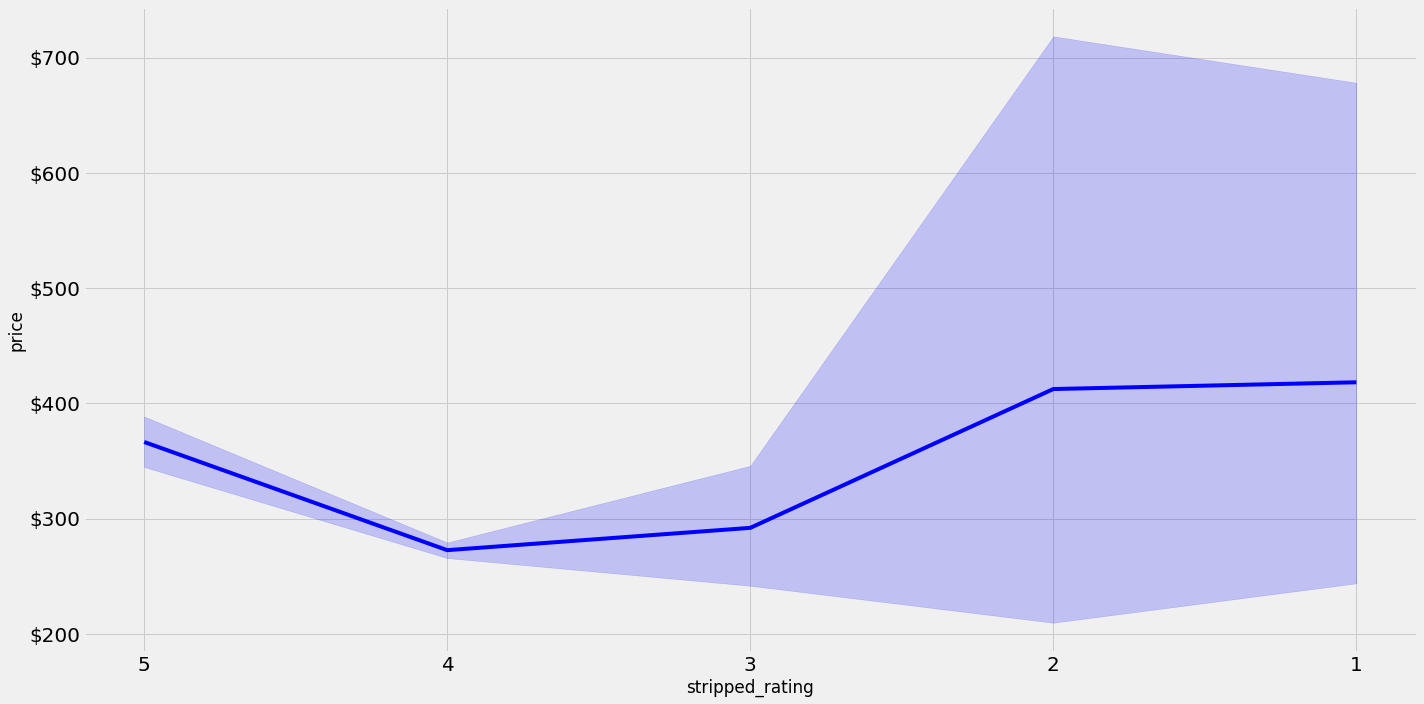

In [451]:
fig, ax = plt.subplots(figsize=(20, 10))

p = sns.lineplot(data=df, x='stripped_rating', y='price', color='blue');


#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

#y1 = p.axvline('2008-01', color='red') #housing market crash begins
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

plt.tight_layout()

plt.show();

### Analysis: 
This is a very basic plot, but seems to show that there is a "sweet spot" for pricing that is around $300.

In [452]:
#new_df = df[df['5+_reviews'] == True]

In [453]:
#new_df['5+_reviews'].value_counts()

In [454]:
scatter_df = df[df['review_scores_rating'] >= 4.0]

In [455]:
scatter_mean = scatter_df['price'].mean()
scatter_mean

293.9845347313237

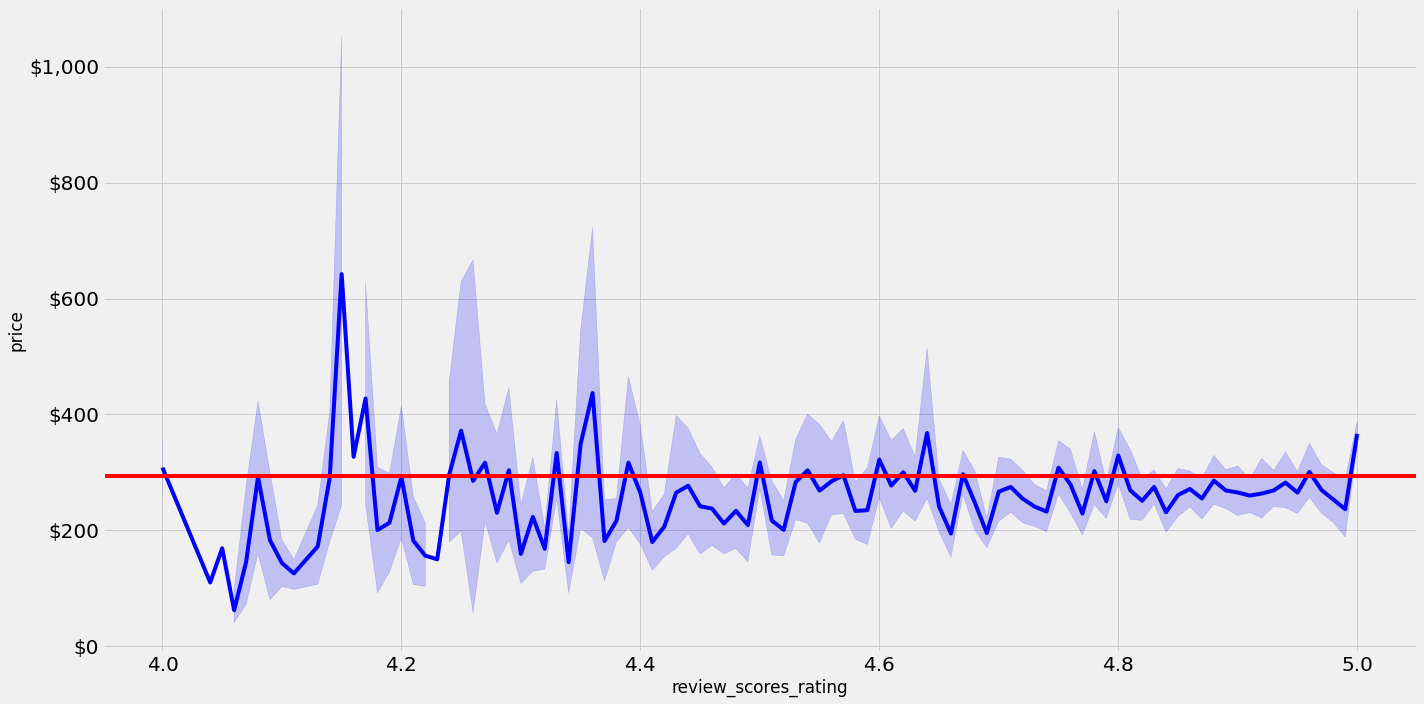

In [456]:
fig, ax = plt.subplots(figsize=(20, 10))

p = sns.lineplot(data=scatter_df, x='review_scores_rating', y='price', color='blue');


#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

y1 = p.axhline(scatter_mean, color='red') 
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

plt.tight_layout()

plt.show();

In [457]:
df.head(1)

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,rating_5,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,communication_5,price_high,price_low,stripped_rating
0,60.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,2,1.0,...,True,True,True,True,False,True,True,False,True,5


In [458]:
df.sort_values('rating_5', ascending=False).head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,rating_5,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,communication_5,price_high,price_low,stripped_rating
0,60.0,5.0,5.0,5.0,5.0,5.00,4.00,5.00,2,1.0,...,True,True,True,True,False,True,True,False,True,5
9843,93.0,5.0,5.0,5.0,5.0,5.00,4.75,4.75,5,1.0,...,True,True,True,True,False,False,True,False,True,5
772,350.0,5.0,5.0,5.0,5.0,4.91,5.00,5.00,2,1.0,...,True,True,True,True,True,True,False,True,False,5
9808,137.0,5.0,5.0,5.0,5.0,5.00,5.00,4.00,4,1.0,...,True,True,True,True,True,False,True,False,False,5
720,160.0,5.0,5.0,5.0,5.0,4.93,5.00,4.93,2,1.0,...,True,True,True,True,True,False,False,False,False,5


### Creating Analysis_df

In [459]:
analysis_df = df.copy()

## Modelling

### Getting Data Ready for Modelling

In [460]:
cont_features = [col for col in df.columns if df[col].dtype in [np.float64, np.int64]]
feature_df = df.loc[:, cont_features]
feature_df.head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,beds,host_id,calculated_host_listings_count,host_response_rate
0,60.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,2,1.0,1.0,43636297,1,100.0
8389,621.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4,2.0,3.0,88168913,219,91.0
8354,366.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6,3.0,3.0,40905770,1,100.0
4305,158.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4,2.0,2.0,29286398,61,40.0
1874,129.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,2,1.0,1.0,19251664,1,100.0


In [461]:
#test_df = df.drop(cont_features, axis=1)

In [462]:
#test_df

In [463]:
#feature_df.drop(['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness',
#                 'review_scores_checkin', 'review_scores_communication','review_scores_value',
#                 'review_scores_location', 'accommodates', 'bedrooms',
#                 'beds'], axis=1, inplace=True#)

In [464]:
#feature_df.drop(['review_scores_location'], axis=1, inplace=True)

In [465]:
feature_df.head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,beds,host_id,calculated_host_listings_count,host_response_rate
0,60.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,2,1.0,1.0,43636297,1,100.0
8389,621.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4,2.0,3.0,88168913,219,91.0
8354,366.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6,3.0,3.0,40905770,1,100.0
4305,158.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4,2.0,2.0,29286398,61,40.0
1874,129.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,2,1.0,1.0,19251664,1,100.0


In [466]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7810 entries, 0 to 5239
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           7810 non-null   float64
 1   review_scores_rating            7810 non-null   float64
 2   review_scores_accuracy          7810 non-null   float64
 3   review_scores_cleanliness       7810 non-null   float64
 4   review_scores_checkin           7810 non-null   float64
 5   review_scores_communication     7810 non-null   float64
 6   review_scores_location          7810 non-null   float64
 7   review_scores_value             7810 non-null   float64
 8   accommodates                    7810 non-null   int64  
 9   bedrooms                        7810 non-null   float64
 10  beds                            7810 non-null   float64
 11  instant_bookable                7810 non-null   object 
 12  property_type                   78

#### One Hot Encoding

In [467]:
need_to_encode = df[['rating_5', 'accuracy_5', 'cleanliness_5', 'checkin_5', 
                    'location_5', 'value_5', 'communication_5', 'price_high', 'price_low', 'room_type',
                     'capacity_couple', 'capacity_family', 'capacity_large',
                    #'capacity_1-4', 'capacity_5+',
                    # 'capacity_-2','capacity_-4', 'capacity_-6', 'capacity_-10', 'capacity_11+',
                    #'bedrooms_1', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4+', 'instant_bookable']]
                     'bedrooms_1-2', 'bedrooms_3+', 'instant_bookable_True', 'booked',
                     'host_listings_5+', 'superhost_True', 'host_response_100', 'host_response_time' 
                    ]]
ohe = OneHotEncoder()
ohe.fit(need_to_encode)

ohe_1 = ohe.transform(need_to_encode).toarray()

ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names(need_to_encode.columns))
ohe_df.head(2)

,rating_5_False,rating_5_True,accuracy_5_False,accuracy_5_True,cleanliness_5_False,cleanliness_5_True,checkin_5_False,checkin_5_True,location_5_False,location_5_True,...,host_listings_5+_False,host_listings_5+_True,superhost_True_False,superhost_True_True,host_response_100_False,host_response_100_True,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [468]:
# Combining everything together
#cleaned_df = pd.concat([pd.DataFrame(feature_df), ohe_df], axis=1)
#cleaned_df.head(2)

In [469]:
cleaned_df = ohe_df

### Top Rated and Low Rated DFs Created

In [470]:
top_rated = cleaned_df[cleaned_df['rating_5_True'] == 1]

In [471]:
low_rated = cleaned_df[cleaned_df['rating_5_False'] == 1]

In [472]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7810 entries, 0 to 7809
Data columns (total 46 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   rating_5_False                         7810 non-null   float64
 1   rating_5_True                          7810 non-null   float64
 2   accuracy_5_False                       7810 non-null   float64
 3   accuracy_5_True                        7810 non-null   float64
 4   cleanliness_5_False                    7810 non-null   float64
 5   cleanliness_5_True                     7810 non-null   float64
 6   checkin_5_False                        7810 non-null   float64
 7   checkin_5_True                         7810 non-null   float64
 8   location_5_False                       7810 non-null   float64
 9   location_5_True                        7810 non-null   float64
 10  value_5_False                          7810 non-null   float64
 11  valu

#### Dropping One Value for Categoricals

In [473]:
cleaned_df = cleaned_df.drop(['rating_5_False', 'accuracy_5_False',
                             'cleanliness_5_False', 'checkin_5_False', 'location_5_False',
                             'value_5_False', 'price_high_False', 'price_low_False',
                           # 'bedrooms_1_False', 'bedrooms_2_False', 'bedrooms_3_False', 'bedrooms_4+_False',
                             'bedrooms_1-2_False', 'bedrooms_3+_False',
                            #'capacity_1-4_False', 'capacity_5+_False',
                             # 'capacity_-2_False','capacity_-4_False', 'capacity_-6_False',
                             # 'capacity_-10_False', 'capacity_11+_False',
                              'capacity_couple_False', 'capacity_family_False', 'capacity_large_False',
                              'instant_bookable_True_False', 'booked_False', 'room_type_Hotel room',
                              'host_response_100_False',
                             'communication_5_False', 'superhost_True_False', 'host_listings_5+_False'],
                              axis=1)

In [ ]:
#top_rated_df = top_rated.drop(['rating_5_False', 'accuracy_5_False',
#                             'cleanliness_5_False', 'checkin_5_False', 'location_5_False',
#                             'value_5_False', 'price_high_False', 'price_low_False',
 #                          # 'bedrooms_1_False', 'bedrooms_2_False', 'bedrooms_3_False', 'bedrooms_4+_False',
  #                           'bedrooms_1-2_False', 'bedrooms_3+_False',
   #                         'capacity_1-4_False', 'capacity_5+_False', 'instant_bookable_f', 'booked_False'],
    #                          axis=1)

In [ ]:
#low_rated_df = low_rated.drop(['rating_5_False', 'accuracy_5_False',
 #                            'cleanliness_5_False', 'checkin_5_False', 'location_5_False',
  #                           'value_5_False', 'price_high_False', 'price_low_False',
   #                        # 'bedrooms_1_False', 'bedrooms_2_False', 'bedrooms_3_False', 'bedrooms_4+_False',
    #                         'bedrooms_1-2_False', 'bedrooms_3+_False',
     #                       'capacity_1-4_False', 'capacity_5+_False', 'instant_bookable_f', 'booked_False'],
      #                        axis=1)

In [ ]:
#Dropping a few of the redundant values.
#cleaned_df= cleaned_df.drop(['rating_5_False', 'accuracy_5_False',
#                             'cleanliness_5_False', 'checkin_5_False', 'location_5_False',
 #                            'value_5_False', 'price_high_False', 'price_low_False',
  #                         # 'bedrooms_1_False', 'bedrooms_2_False', 'bedrooms_3_False', 'bedrooms_4+_False',
   #                          'bedrooms_1-2_False', 'bedrooms_3+_False',
    #                        'capacity_1-4_False', 'capacity_5+_False', 'instant_bookable_f'], axis=1)

In [ ]:
#cleaned_df= cleaned_df.drop(['price_low_True', 'price_high_True'], axis=1)
#cleaned_df= cleaned_df.drop(['price'], axis=1)

In [ ]:
#cleaned_df.head(1)

In [474]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7810 entries, 0 to 7809
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   rating_5_True                          7810 non-null   float64
 1   accuracy_5_True                        7810 non-null   float64
 2   cleanliness_5_True                     7810 non-null   float64
 3   checkin_5_True                         7810 non-null   float64
 4   location_5_True                        7810 non-null   float64
 5   value_5_True                           7810 non-null   float64
 6   communication_5_True                   7810 non-null   float64
 7   price_high_True                        7810 non-null   float64
 8   price_low_True                         7810 non-null   float64
 9   room_type_Entire home/apt              7810 non-null   float64
 10  room_type_Private room                 7810 non-null   float64
 11  room

In [484]:
#dropping redundant columns
cleaned_df.drop(['host_response_time_a few days or more', 'room_type_Private room', 'room_type_Shared room',
               'capacity_family_True', 'bedrooms_3+_True'], axis=1, inplace=True)

In [489]:
#cleaned_df.drop(['bedrooms_3+_True'], axis=1, inplace=True)

In [490]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7810 entries, 0 to 7809
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   rating_5_True                          7810 non-null   float64
 1   accuracy_5_True                        7810 non-null   float64
 2   cleanliness_5_True                     7810 non-null   float64
 3   checkin_5_True                         7810 non-null   float64
 4   location_5_True                        7810 non-null   float64
 5   value_5_True                           7810 non-null   float64
 6   communication_5_True                   7810 non-null   float64
 7   price_high_True                        7810 non-null   float64
 8   price_low_True                         7810 non-null   float64
 9   room_type_Entire home/apt              7810 non-null   float64
 10  capacity_couple_True                   7810 non-null   float64
 11  capa

#### Dealing with Class Imbalance

- Rentals without at 5.0 rating are at a rate of 3.4 to 1.
- <b> Solution </b>
    - Always use class weight parameter in Decision Tree Classifier
    - Always stratify Train Test Split.
    - Add SMOTE to Training Sets.

In [491]:
cleaned_df['rating_5_True']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
7805    0.0
7806    0.0
7807    0.0
7808    0.0
7809    0.0
Name: rating_5_True, Length: 7810, dtype: float64

In [492]:
cleaned_df.isna().sum()

rating_5_True                            0
accuracy_5_True                          0
cleanliness_5_True                       0
checkin_5_True                           0
location_5_True                          0
value_5_True                             0
communication_5_True                     0
price_high_True                          0
price_low_True                           0
room_type_Entire home/apt                0
capacity_couple_True                     0
capacity_large_True                      0
bedrooms_1-2_True                        0
instant_bookable_True_True               0
booked_True                              0
host_listings_5+_True                    0
superhost_True_True                      0
host_response_100_True                   0
host_response_time_within a day          0
host_response_time_within a few hours    0
host_response_time_within an hour        0
dtype: int64

In [ ]:
#cleaned_df = cleaned_df.dropna()
#top_rated_df = top_rated_df.dropna()
#low_rated_df = low_rated_df.dropna()

In [ ]:
#top_rated_df.isna().sum()

In [ ]:
#cleaned_df.info()

In [ ]:
#cleaned_df.isna().sum()

In [ ]:
#cleaned_df.drop(['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'price'], axis=1, inplace=True)

In [ ]:
#dropping accuracy to see what the feature importances are
#cleaned_df.drop(['accuracy_5_True'], axis=1, inplace=True)

In [ ]:
#dropping rating_5 and searching for accuracy as the target
#cleaned_df.drop(['rating_5_True'], axis=1, inplace=True)
#top_rated_df.drop(['rating_5_True'], axis=1, inplace=True)
#low_rated_df.drop(['rating_5_True'], axis=1, inplace=True)

In [ ]:
# dropping price_high as it is redundant
# price_low means that the listing is below the mean avg price
#cleaned_df.drop(['price_high_True'], axis=1, inplace=True)
#top_rated_df.drop(['price_high_True'], axis=1, inplace=True)
#low_rated_df.drop(['price_high_True'], axis=1, inplace=True)

In [493]:
booked_df = cleaned_df[cleaned_df['booked_True'] == 1]
booked_df.head()

,rating_5_True,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True,price_high_True,price_low_True,room_type_Entire home/apt,...,capacity_large_True,bedrooms_1-2_True,instant_bookable_True_True,booked_True,host_listings_5+_True,superhost_True_True,host_response_100_True,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
5,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


In [494]:
booked_df.mean()

rating_5_True                            0.252340
accuracy_5_True                          0.286177
cleanliness_5_True                       0.249460
checkin_5_True                           0.395968
location_5_True                          0.329014
value_5_True                             0.179986
communication_5_True                     0.402808
price_high_True                          0.193665
price_low_True                           0.309575
room_type_Entire home/apt                0.816055
capacity_couple_True                     0.301296
capacity_large_True                      0.652268
bedrooms_1-2_True                        0.771058
instant_bookable_True_True               0.388049
booked_True                              1.000000
host_listings_5+_True                    0.313175
superhost_True_True                      0.538517
host_response_100_True                   0.755220
host_response_time_within a day          0.087113
host_response_time_within a few hours    0.153708


In [ ]:
#cleaned_df.head(1)

In [ ]:
#top_rated_df.describe()

In [ ]:
#new_df = top_rated_df[['checkin_5_True', 'location_5_True', 'price_low_True', 'capacity_5+_True',
#                    'instant_bookable_t', 'booked_True']]

In [495]:
balanced_df = cleaned_df.copy()
#balanced_df = top_rated_df.copy()
#balanced_df = new_df.copy()

#balanced_df.drop(['rating_5_True', 'accuracy_5_True'], axis=1, inplace=True)

X = balanced_df.drop(['rating_5_True'], axis=1)
y = balanced_df['rating_5_True']
#X = balanced_df.drop(['accuracy_5_True'], axis=1)
#y = balanced_df['accuracy_5_True']
#X = balanced_df.drop(['communication_5_True'], axis=1)
#y = balanced_df['communication_5_True']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)

smote = SMOTE(random_state=23)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

### Metrics Function

In [496]:
def get_metrics(clf, y_pred):
    
    
    #clf_acc = accuracy_score(y_test, y_pred) * 100
    #print('Accuracy is :{0}'.format(clf_acc))
    clf_prec = precision_score(y_test, y_pred) * 100
    print('Precision is :{0}'.format(clf_prec))
    clf_rcl = recall_score(y_test, y_pred) * 100
    print('Recall is :{0}'.format(clf_rcl))
    clf_f1 = f1_score(y_test, y_pred) * 100
    print('F1 Score is :{0}'.format(clf_f1))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    clf_roc_auc = auc(false_positive_rate, true_positive_rate)
    print('ROC AUC is :{0}'.format(round(clf_roc_auc, 2)))
    clf_cv_score = np.mean(cross_val_score(clf, X_train_resampled, y_train_resampled, cv=10))
    print('Cross Validation Score is :{0}'.format(round(clf_cv_score, 3)))

### Choosing Evaluation Metrics
- My goal is to predict whether a person will get a perfect 5.0 Airbnb rating.
- Which is worse?
    - Model predicts that someone has a perfect rating, but they actually don't? (more false Positives)
    - Model predicts that someone does not have a perfect rating, but they actually do? (more false negatives)

<b> Decision </b>
- I want false Positives to be as low as possible.
- If my model says that a property will have a 5.0 score, I want it to be a near guarantee.
- If it misses some that will still get a 5.0 score that is fine.
- <b>Therefore, I am most concerned with Precision, balanced out by F1 score.</b>

## Baseline Decision Tree

In [497]:
#w/out SMOTE
dt0 = DecisionTreeClassifier(random_state=23, class_weight="balanced")
dt0.fit(X_train, y_train)
dt0_y_pred = dt0.predict(X_test)
get_metrics(dt0, dt0_y_pred)

Precision is :66.66666666666666
Recall is :74.364896073903
F1 Score is :70.3056768558952
ROC AUC is :0.82
Cross Validation Score is :0.912


In [498]:
dt1 = DecisionTreeClassifier(random_state=23, class_weight="balanced")
dt1.fit(X_train_resampled, y_train_resampled)
dt1_y_pred = dt1.predict(X_test)
get_metrics(dt1, dt1_y_pred)

Precision is :75.29411764705883
Recall is :73.90300230946882
F1 Score is :74.5920745920746
ROC AUC is :0.83
Cross Validation Score is :0.912


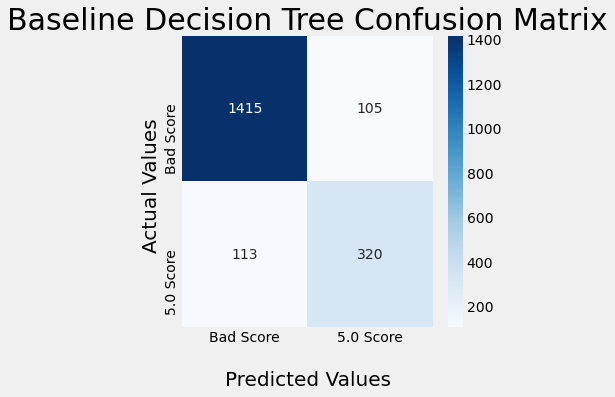

In [499]:
dt1_matrix = confusion_matrix(y_test, dt1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Baseline Decision Tree Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Refining Decision Tree through GridSearchCV

In [500]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [503]:
# Instantiate GridSearchCV
dt2 = DecisionTreeClassifier(random_state=23)

dt_grid_search = GridSearchCV(dt2, dt_param_grid, cv=3, scoring = 'precision')

# Fit to the data
dt_grid_search.fit(X_train_resampled, y_train_resampled)
dt_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5}

## Decision Tree 2

In [502]:
dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=5,
                             min_samples_leaf=2, class_weight='balanced', random_state=23)
dt2.fit(X_train_resampled, y_train_resampled)
dt2_y_pred = dt2.predict(X_test)
get_metrics(dt2, dt2_y_pred)

Precision is :77.1712158808933
Recall is :71.82448036951502
F1 Score is :74.40191387559808
ROC AUC is :0.83
Cross Validation Score is :0.912


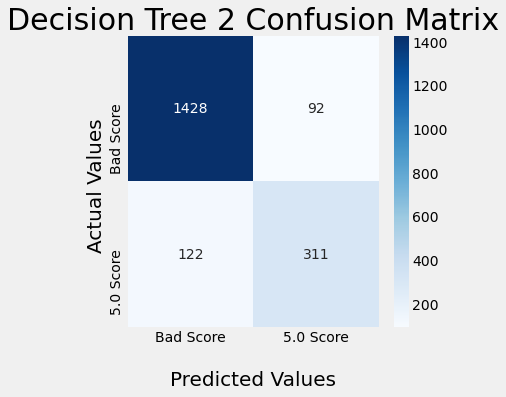

In [504]:
dt2_matrix = confusion_matrix(y_test, dt2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Decision Tree 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Random Forests

In [505]:
rf1_clf = RandomForestClassifier(random_state=23, class_weight="balanced")
rf1_clf.fit(X_train_resampled, y_train_resampled)
rf1_y_pred = rf1_clf.predict(X_test)
get_metrics(rf1_clf, rf1_y_pred)

Precision is :76.05321507760532
Recall is :79.21478060046189
F1 Score is :77.60180995475113
ROC AUC is :0.86
Cross Validation Score is :0.933


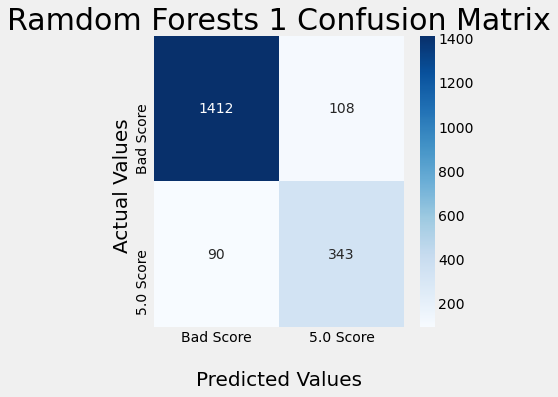

In [506]:
rf1_matrix = confusion_matrix(y_test, rf1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(rf1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Ramdom Forests 1 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### GridSearch CV

In [507]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [508]:
rf2_clf = RandomForestClassifier(random_state=23)


rf1_grid_search= GridSearchCV(rf2_clf, rf_param_grid, scoring = 'precision', cv=3)
rf1_grid_search.fit(X_train_resampled, y_train_resampled)

print("")
print(f"Random Forest  Optimal Parameters: {rf1_grid_search.best_params_}")


Random Forest  Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


## Random Forests 2

In [509]:
rf2_clf = RandomForestClassifier(criterion= 'entropy', max_depth= None, min_samples_leaf= 3,
                                min_samples_split= 5, n_estimators= 100, random_state=23,
                                class_weight='balanced')
rf2_clf.fit(X_train_resampled, y_train_resampled)
rf2_y_pred = rf2_clf.predict(X_test)
get_metrics(rf2_clf, rf2_y_pred)

Precision is :77.07006369426752
Recall is :83.83371824480369
F1 Score is :80.30973451327435
ROC AUC is :0.88
Cross Validation Score is :0.932


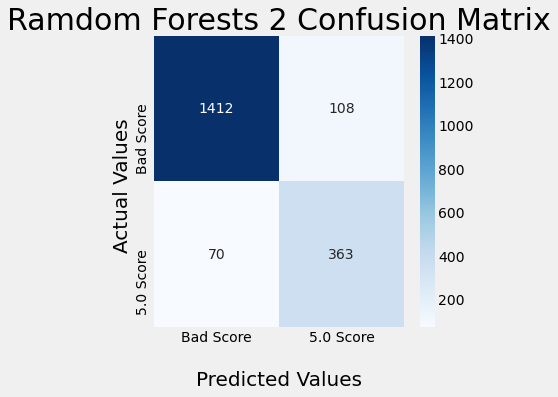

In [510]:
rf2_matrix = confusion_matrix(y_test, rf2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(rf2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Ramdom Forests 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## XGBoost Model

In [511]:
# Instantiate XGBClassifier
clf = XGBClassifier(random_state=23)

# Fit XGBClassifier
xg1 = clf.fit(X_train_resampled, y_train_resampled)

# Predict on training and test sets
training_preds = clf.predict(X_train_resampled)
xg1_y_pred = clf.predict(X_test)
get_metrics(xg1, xg1_y_pred)

Precision is :77.59433962264151
Recall is :75.98152424942263
F1 Score is :76.77946324387399
ROC AUC is :0.85
Cross Validation Score is :0.928


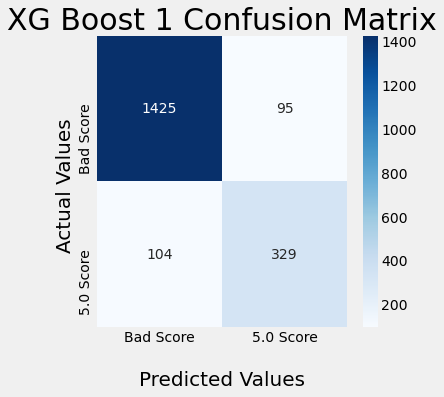

In [512]:
xg1_matrix = confusion_matrix(y_test, xg1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(xg1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('XG Boost 1 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### GridSearch

In [513]:
boost_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

## XGBoost 2

In [514]:
xg2 = XGBClassifier(random_state=23)

grid_clf = GridSearchCV(xg2, boost_param_grid, scoring='precision', cv=3, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7


In [515]:
xg2 = XGBClassifier(learning_rate= 0.2, max_depth=6, min_child_weight=1,
                                n_estimators=100, subsample=0.7, random_state=23)
xg2.fit(X_train_resampled, y_train_resampled)
xg2_y_pred = xg2.predict(X_test)
get_metrics(xg2, xg2_y_pred)

Precision is :77.85388127853882
Recall is :78.75288683602771
F1 Score is :78.300803673938
ROC AUC is :0.86
Cross Validation Score is :0.931


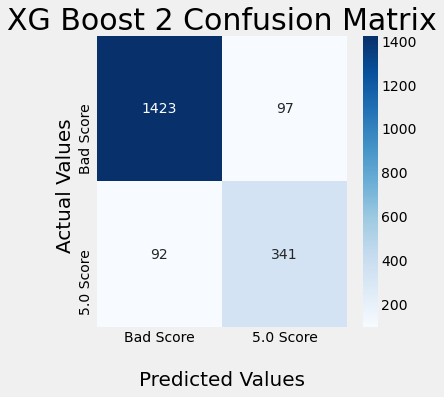

In [516]:
xg2_matrix = confusion_matrix(y_test, xg2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(xg2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('XG Boost 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## FINAL MODEL = XG Boost 2

In [517]:
get_metrics(xg2, xg2_y_pred)
#get_metrics(rf1_clf, rf1_y_pred)

Precision is :77.85388127853882
Recall is :78.75288683602771
F1 Score is :78.300803673938
ROC AUC is :0.86
Cross Validation Score is :0.931


### Model Evaluation: (needs to be updated)
- <b> Precision: </b> This Model correctly picks whether a rental will receive a perfect 5 star overall AirBnb rating 79.4% of the time.
    - This is 30% better than random guessing.
    - The Final Model is also a slight improvement over the baseline model. (about 2% better)
- <b> Recall and F1 Score: </b> The Final Model's recall and F1 Scores are also slightly higher than the baseline model. The F1 Score indicates that the Precision is balanced well with Recall.
- <b> ROC AUC Score: </b> Shows the True Positive Rate vs. the False Postive Rate. My Random Forests 2 Model performed better on this metric, but also captured more false positives. I want to avoid false positives if at all possible, so I chose XG Boost 2 over Random Forests 2.
- <b> Cross Validation Score: </b> The high score shows that this model does a good job with new data that it was not trained on.


## Feature Importance

In [518]:
feature_names = list(X)
feature_names

['accuracy_5_True',
 'cleanliness_5_True',
 'checkin_5_True',
 'location_5_True',
 'value_5_True',
 'communication_5_True',
 'price_high_True',
 'price_low_True',
 'room_type_Entire home/apt',
 'capacity_couple_True',
 'capacity_large_True',
 'bedrooms_1-2_True',
 'instant_bookable_True_True',
 'booked_True',
 'host_listings_5+_True',
 'superhost_True_True',
 'host_response_100_True',
 'host_response_time_within a day',
 'host_response_time_within a few hours',
 'host_response_time_within an hour']

In [519]:
xg2_importance = xg2.feature_importances_
xg2_importance

array([0.42394996, 0.05110184, 0.05095703, 0.03066926, 0.04941604,
       0.13143452, 0.02317695, 0.02138124, 0.01663024, 0.01868187,
       0.01580083, 0.01512598, 0.02014683, 0.01812967, 0.02305761,
       0.02672674, 0.01715126, 0.01532904, 0.01649427, 0.0146387 ],
      dtype=float32)

In [520]:
#feature_importance_df = pd.DataFrame(dt2_importance, feature_names)
#feature_importance_df = pd.DataFrame(rf1_importance, feature_names)
feature_importance_df = pd.DataFrame(xg2_importance, feature_names)
feature_importance_df= feature_importance_df.reset_index()
feature_importance_df.rename(columns={'index': 'Feature', 0: 'Importance'}, inplace=True)
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

,Feature,Importance
0,accuracy_5_True,0.423950
5,communication_5_True,0.131435
1,cleanliness_5_True,0.051102
2,checkin_5_True,0.050957
4,value_5_True,0.049416
3,location_5_True,0.030669
15,superhost_True_True,0.026727
6,price_high_True,0.023177
14,host_listings_5+_True,0.023058
7,price_low_True,0.021381


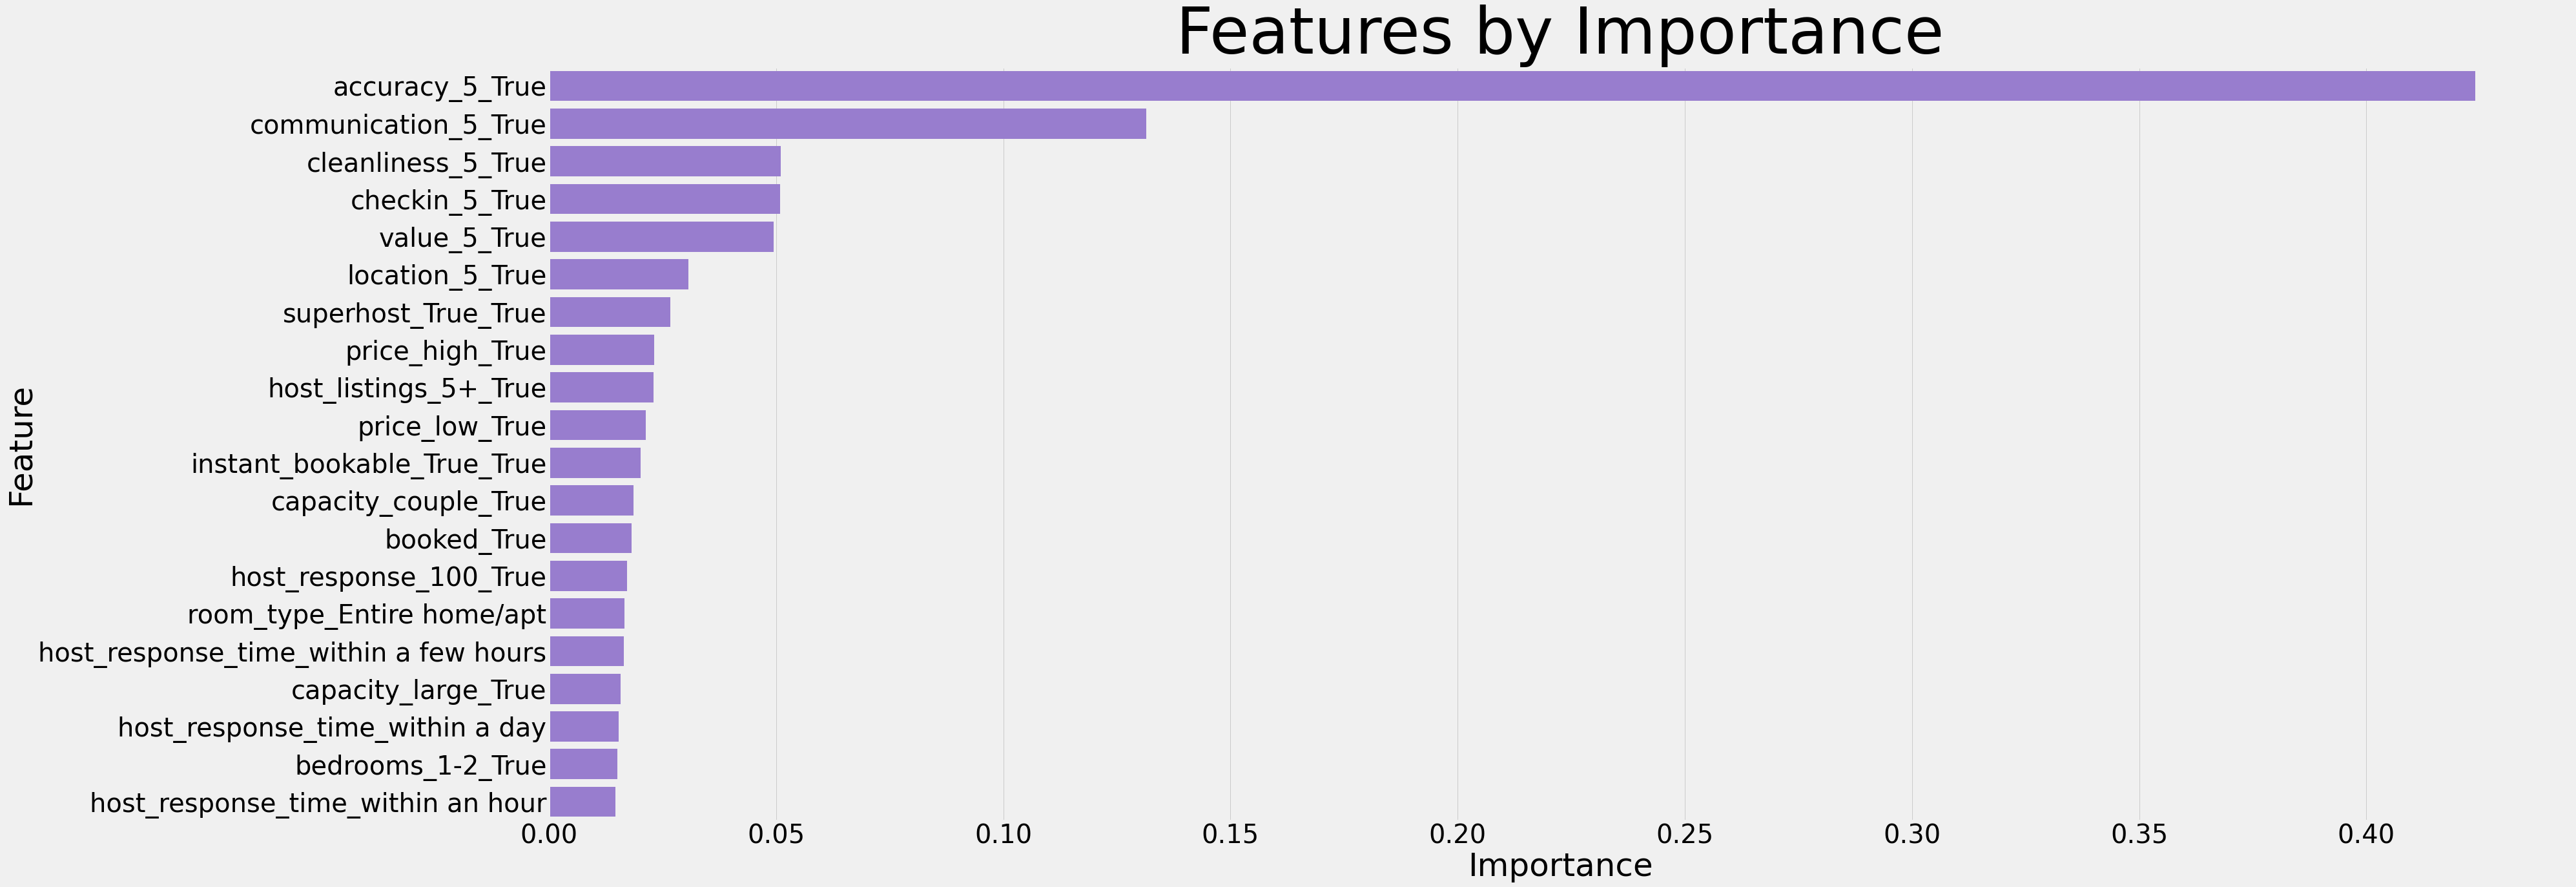

In [521]:
# plot feature importance
fig, ax = plt.subplots(figsize=(50,20))
p = sns.barplot(data=feature_importance_df, x='Importance', y='Feature', color ='mediumpurple' );
p.set_xlabel("Importance", fontsize = 50)

p.set_ylabel("Feature", fontsize = 50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

p.set_title("Features by Importance", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

## <b>Review Metric DF (or Feature Analysis DF)</b>

In [525]:
review_metrics = df[['rating_5', 'accuracy_5', 'communication_5','cleanliness_5', 'checkin_5', 'location_5',
                     'value_5', 'superhost_True', 'host_listings_5+', 'instant_bookable_True', 'booked', 
                     'capacity_couple', 'capacity_family', 'capacity_large', 'host_response_100',
                     'room_type', 'host_response_time','bedrooms_1-2', 'bedrooms_3+']]

In [527]:
review_metrics.head(2)

,rating_5,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost_True,host_listings_5+,instant_bookable_True,booked,capacity_couple,capacity_family,capacity_large,host_response_100,room_type,host_response_time,bedrooms_1-2,bedrooms_3+
0,True,True,True,True,True,False,True,False,False,True,True,True,False,True,True,Private room,within an hour,True,False
8389,True,True,True,True,True,True,True,True,True,True,False,False,False,True,False,Entire home/apt,within an hour,True,False


In [ ]:
#review_metrics['instant_bookable'] = review_metrics['instant_bookable'].astype('bool')
#review_metrics['host_is_superhost'] = review_metrics['host_is_superhost'].astype('bool')

In [529]:
review_metrics['instant_bookable_True'].value_counts()

False    4114
True     3696
Name: instant_bookable_True, dtype: int64

## Function get_stats( )

In [530]:
def get_stats(df):
    
    df_transposed = df.transpose()
    df_transposed = df_transposed.reset_index()
    df_transposed.rename(columns={'index': 'Metric'}, inplace=True)
    stats_df = df_transposed
    total = stats_df.apply(lambda x: x[False] + x[True], axis=1)
    stats_df['total'] = total
    mean = stats_df.apply(lambda x: x[True] / x['total'], axis=1)
    stats_df['mean'] = mean

    return stats_df. sort_values('mean', ascending=False)

In [532]:
def plot_stats(df):
    
    fig, ax = plt.subplots(figsize=(50,20))
    p = sns.lineplot(data=df.head(10), x='Metric', y='mean', color ='seagreen' );
    p.set_ylabel("Percentage of 5 Star Rentals", fontsize = 50)

    p.set_xlabel("Feature", fontsize = 50)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=40)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

    p.set_title("Frequency of Features in 5 Star Rentals ", fontsize = 100)
    plt.figsize=(30,20) 

    return plt.show();

### Accuracy Stats

In [533]:
accuracy_metrics = review_metrics.groupby('accuracy_5').sum()
accuracy_metrics

,rating_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost_True,host_listings_5+,instant_bookable_True,booked,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1-2,bedrooms_3+
accuracy_5,,,,,,,,,,,,,,,,
False,317,1102,490,1110,943,167,3127,2512,2885,1983,1418,332,3439,4282,4366,1440
True,1416,1673,1339,1616,1433,1064,872,692,811,795,590,113,1214,1439,1385,619


In [534]:
accuracy_stats = get_stats(accuracy_metrics)
accuracy_stats

accuracy_5,Metric,False,True,total,mean
5,value_5,167,1064,1231,0.864338
0,rating_5,317,1416,1733,0.817080
2,cleanliness_5,490,1339,1829,0.732094
4,location_5,943,1433,2376,0.603114
1,communication_5,1102,1673,2775,0.602883
3,checkin_5,1110,1616,2726,0.592810
15,bedrooms_3+,1440,619,2059,0.300631
10,capacity_couple,1418,590,2008,0.293825
9,booked,1983,795,2778,0.286177
12,capacity_large,3439,1214,4653,0.260907


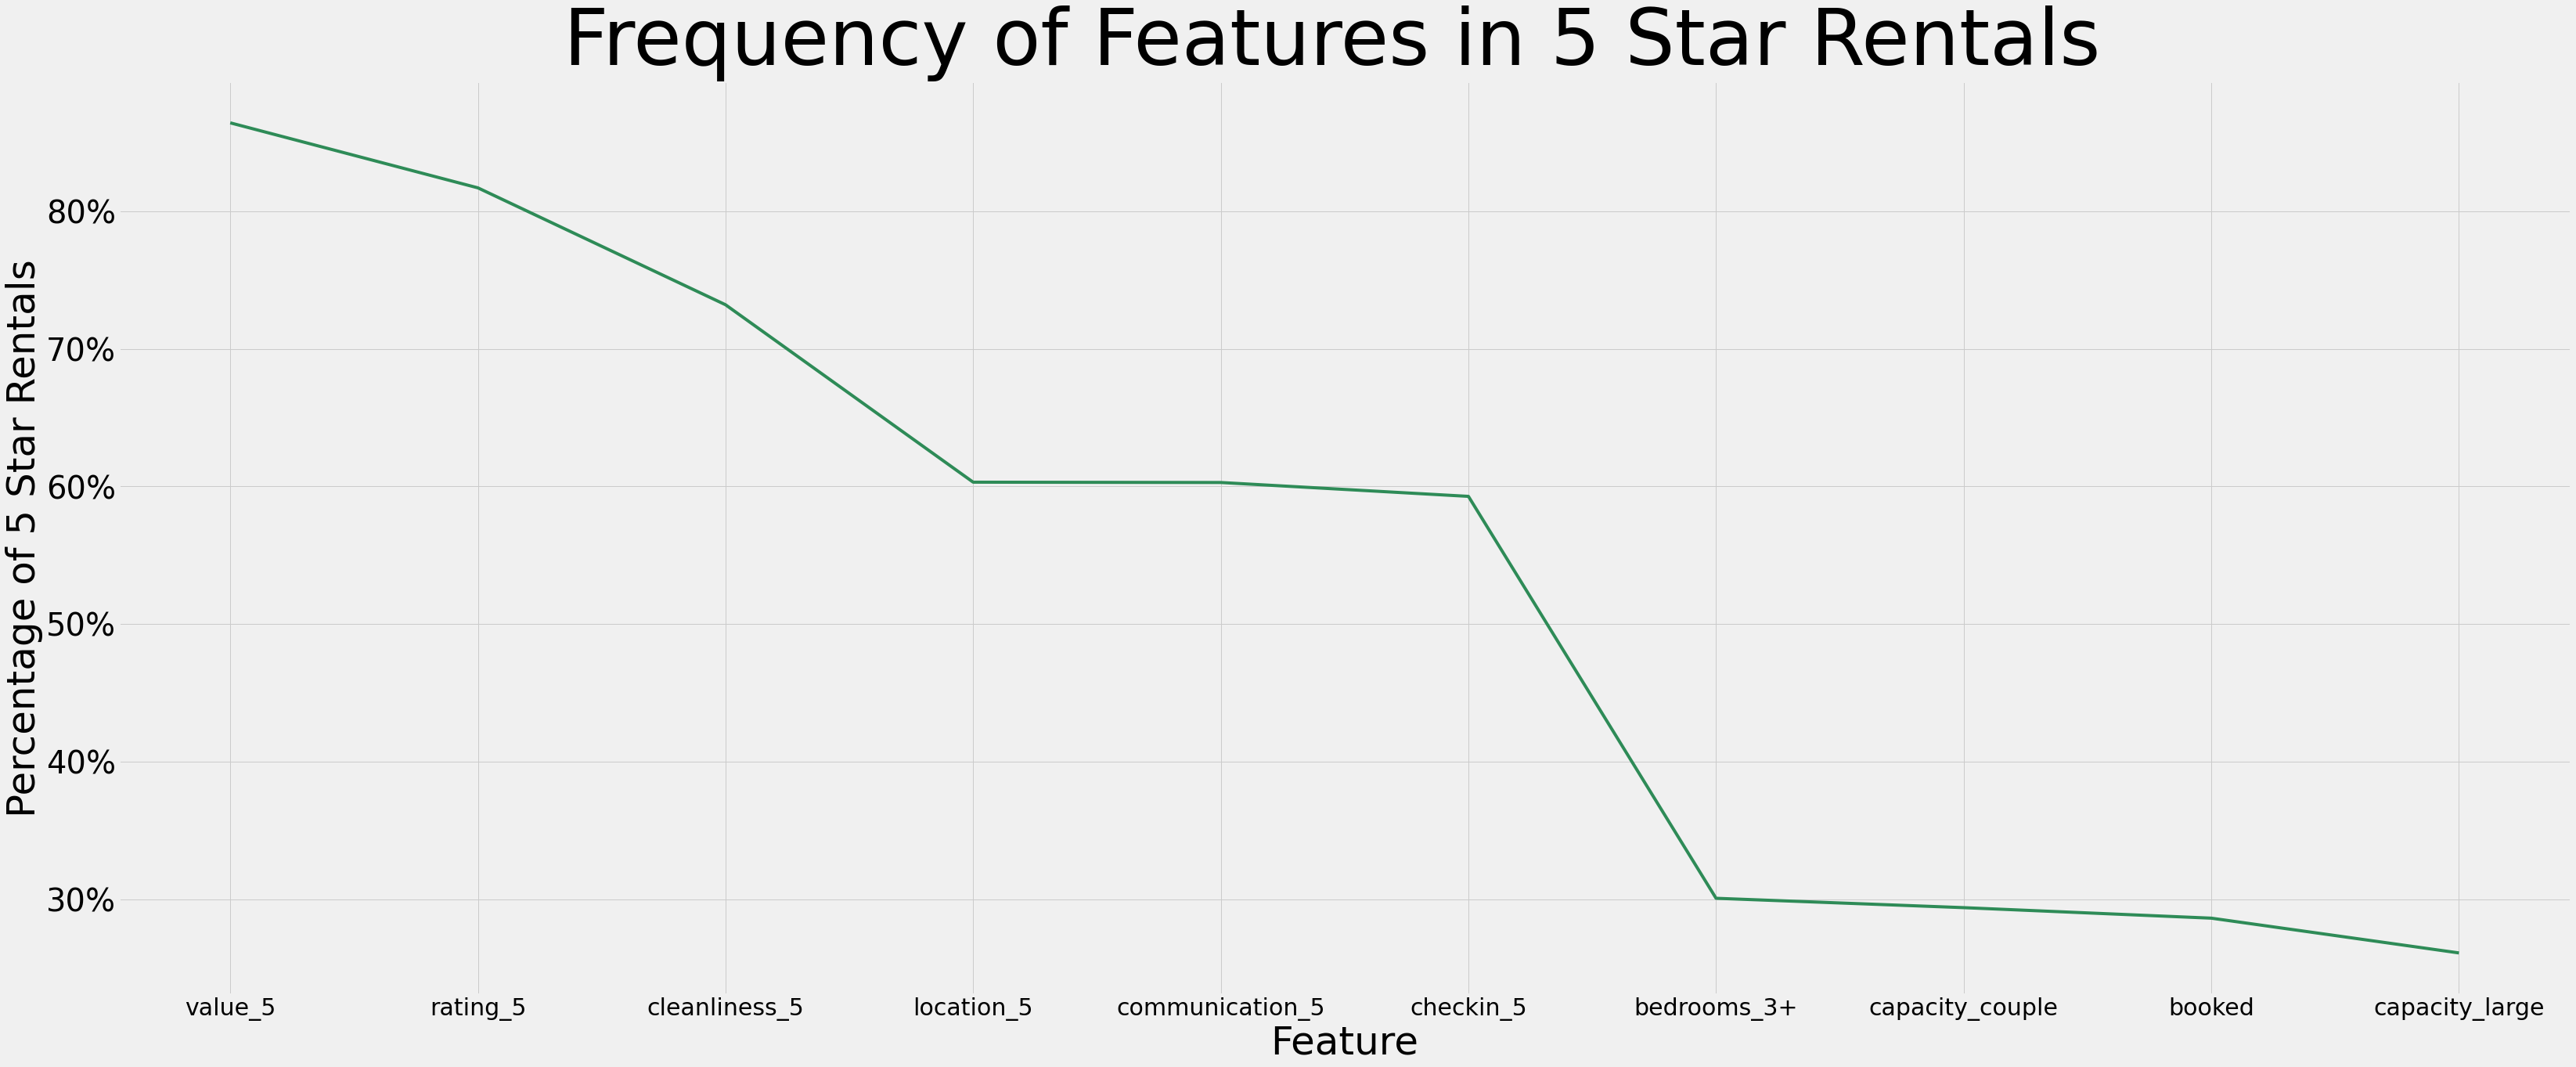

In [535]:
accuracy_plot = plot_stats(accuracy_stats)
accuracy_plot

### Communication Stats

In [536]:
communication_metrics = review_metrics.groupby('communication_5').sum()
communication_metrics

,rating_5,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,superhost_True,host_listings_5+,instant_bookable_True,booked,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1-2,bedrooms_3+
communication_5,,,,,,,,,,,,,,,,
False,206,331,359,615,680,114,2618,2256,2573,1659,1225,281,3002,3643,3802,1233
True,1527,1673,1470,2111,1696,1117,1381,948,1123,1119,783,164,1651,2078,1949,826


In [537]:
communication_stats = get_stats(communication_metrics)
communication_stats

communication_5,Metric,False,True,total,mean
5,value_5,114,1117,1231,0.907392
0,rating_5,206,1527,1733,0.881131
1,accuracy_5,331,1673,2004,0.834830
2,cleanliness_5,359,1470,1829,0.803718
3,checkin_5,615,2111,2726,0.774395
4,location_5,680,1696,2376,0.713805
9,booked,1659,1119,2778,0.402808
15,bedrooms_3+,1233,826,2059,0.401166
10,capacity_couple,1225,783,2008,0.389940
11,capacity_family,281,164,445,0.368539


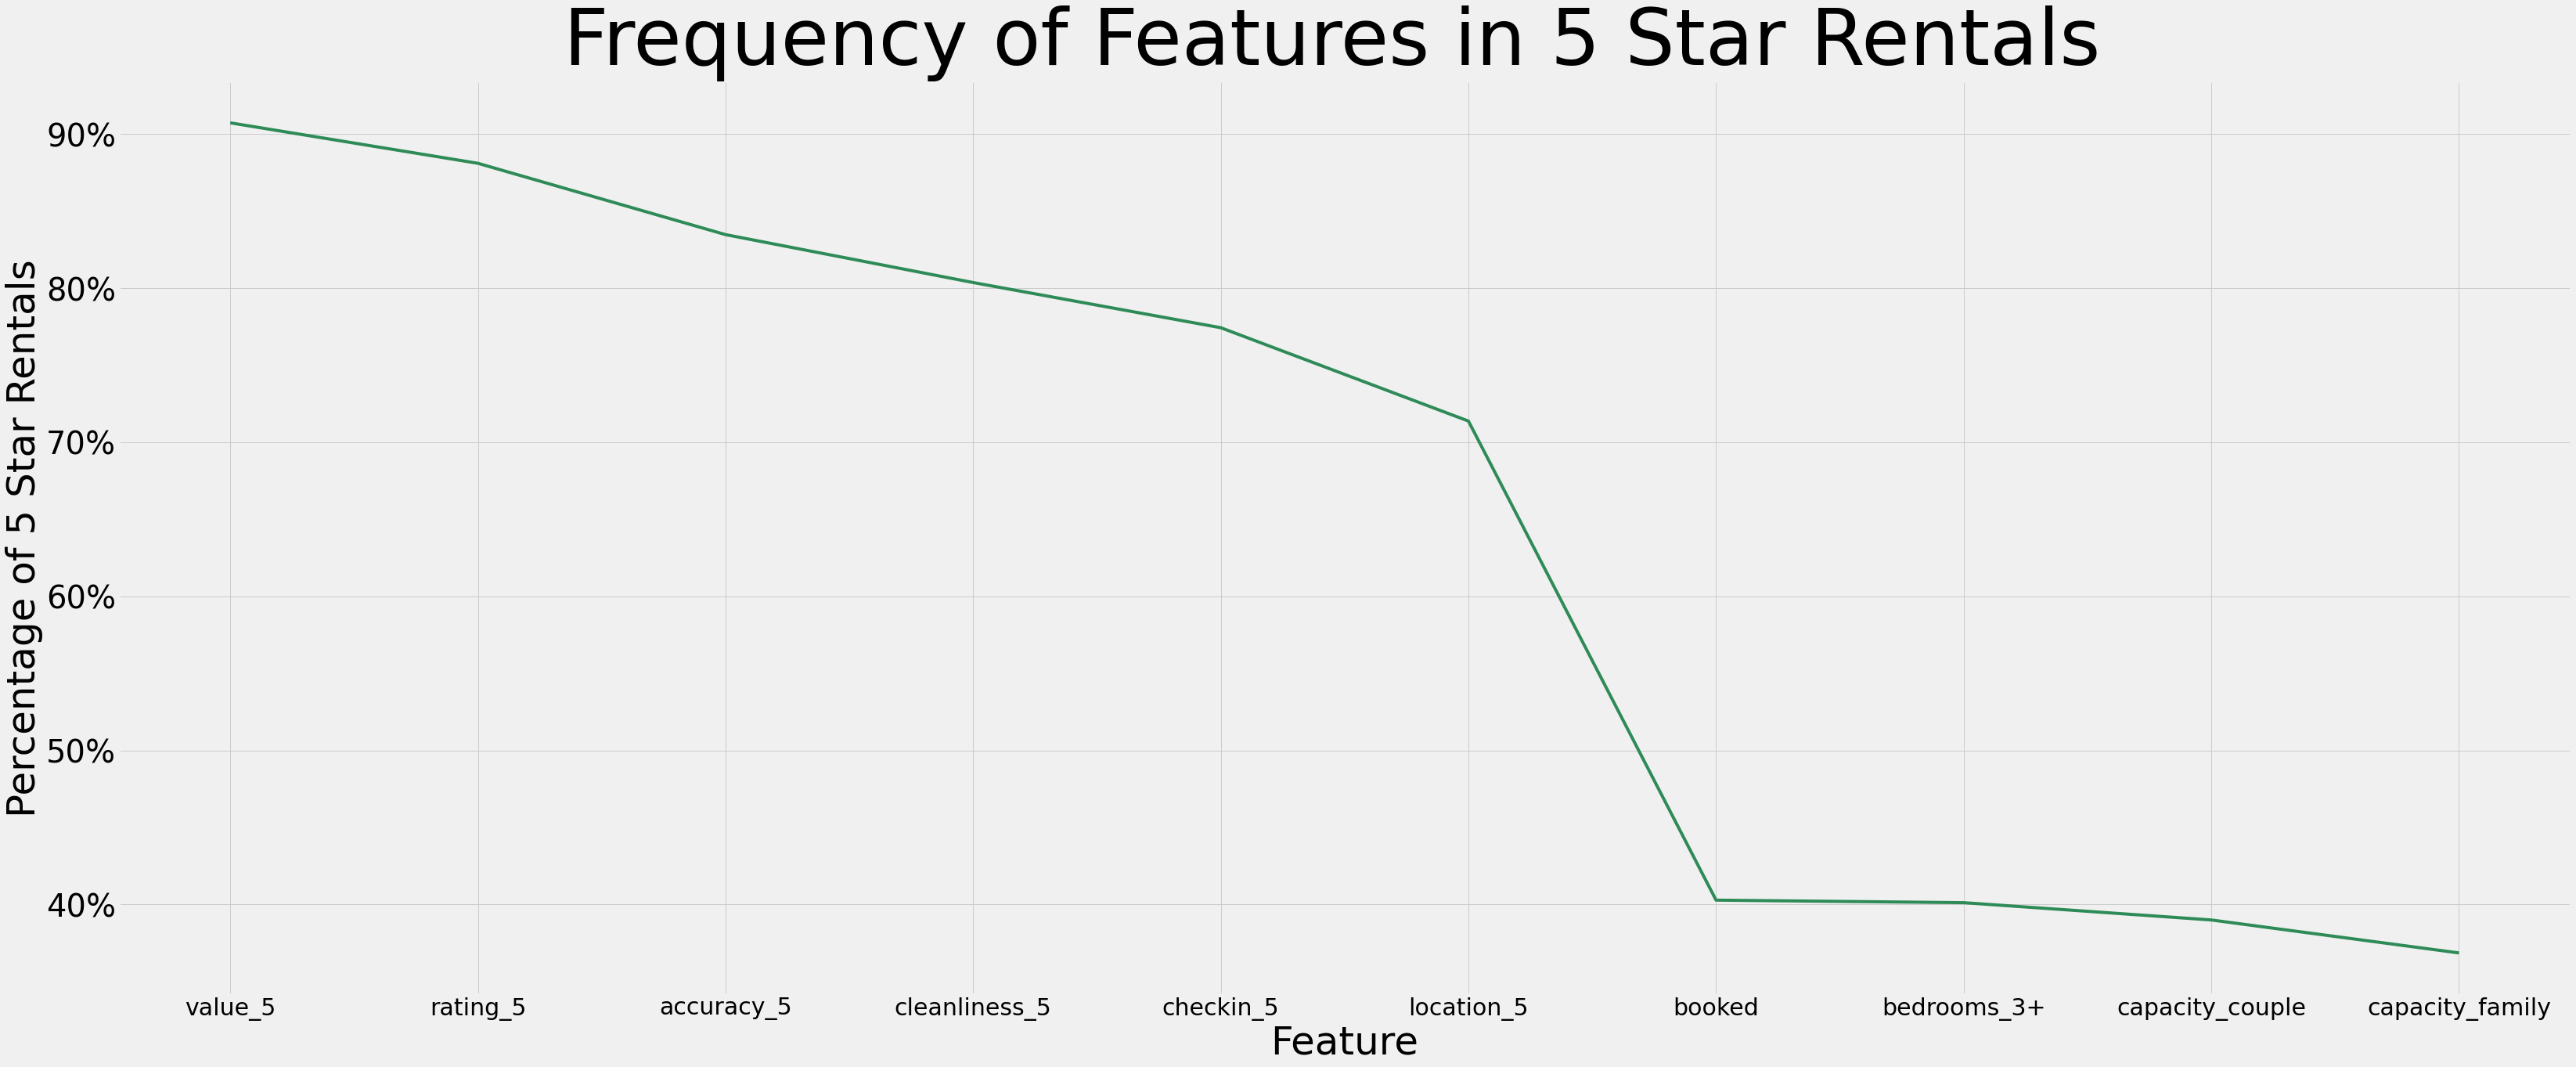

In [538]:
communication_plot = plot_stats(communication_stats)
communication_plot

### Superhost Stats

In [565]:
review_metrics['superhost_True'].value_counts()

True     3999
False    3811
Name: superhost_True, dtype: int64

In [550]:
superhost_metrics = review_metrics.groupby('superhost_True').sum()
superhost_metrics

,rating_5,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,host_listings_5+,instant_bookable_True,booked,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1-2,bedrooms_3+
superhost_True,,,,,,,,,,,,,,,,
False,974,1132,1394,1036,1432,1416,814,1828,1912,1282,920,212,2200,2461,2762,1049
True,759,872,1381,793,1294,960,417,1376,1784,1496,1088,233,2453,3260,2989,1010


In [551]:
superhost_stats = get_stats(superhost_metrics)
superhost_stats

superhost_True,Metric,False,True,total,mean
13,host_response_100,2461,3260,5721,0.569830
10,capacity_couple,920,1088,2008,0.541833
9,booked,1282,1496,2778,0.538517
12,capacity_large,2200,2453,4653,0.527187
11,capacity_family,212,233,445,0.523596
14,bedrooms_1-2,2762,2989,5751,0.519736
2,communication_5,1394,1381,2775,0.497658
15,bedrooms_3+,1049,1010,2059,0.490529
8,instant_bookable_True,1912,1784,3696,0.482684
4,checkin_5,1432,1294,2726,0.474688


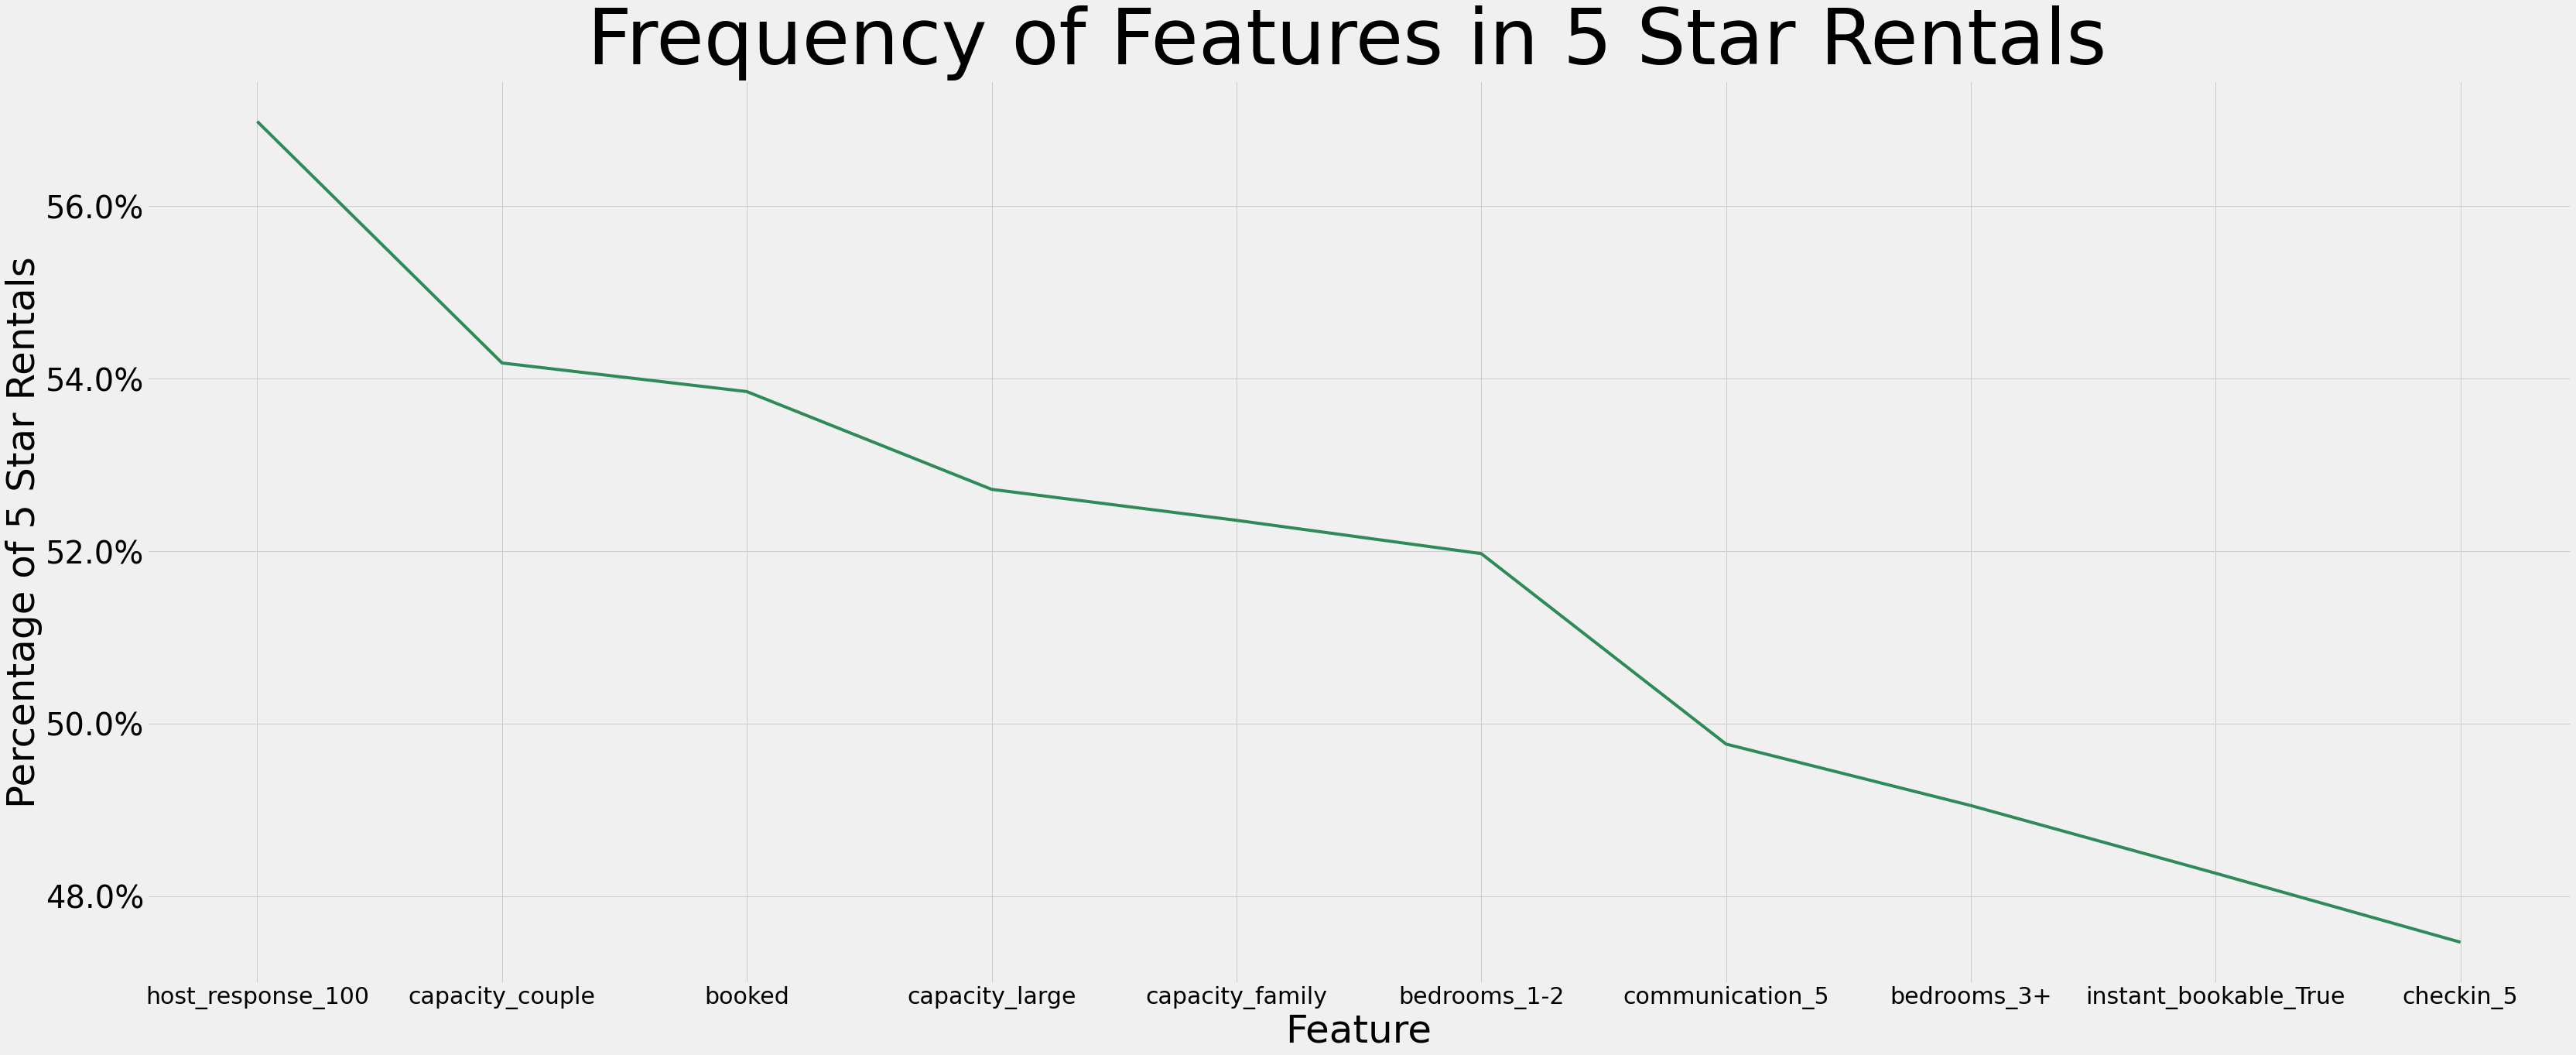

In [552]:
superhost_plot = plot_stats(superhost_stats)
superhost_plot

### Cleanliness Stats

In [542]:
cleanliness_metrics = review_metrics.groupby('cleanliness_5').sum()
cleanliness_metrics

,rating_5,accuracy_5,communication_5,checkin_5,location_5,value_5,superhost_True,host_listings_5+,instant_bookable_True,booked,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1-2,bedrooms_3+
cleanliness_5,,,,,,,,,,,,,,,,
False,457,665,1305,1270,1109,256,3206,2524,2944,2085,1454,348,3552,4419,4469,1512
True,1276,1339,1470,1456,1267,975,793,680,752,693,554,97,1101,1302,1282,547


In [543]:
cleanliness_stats = get_stats(cleanliness_metrics)
cleanliness_stats

cleanliness_5,Metric,False,True,total,mean
5,value_5,256,975,1231,0.792039
0,rating_5,457,1276,1733,0.736295
1,accuracy_5,665,1339,2004,0.668164
3,checkin_5,1270,1456,2726,0.534116
4,location_5,1109,1267,2376,0.533249
2,communication_5,1305,1470,2775,0.529730
10,capacity_couple,1454,554,2008,0.275896
15,bedrooms_3+,1512,547,2059,0.265663
9,booked,2085,693,2778,0.249460
12,capacity_large,3552,1101,4653,0.236622


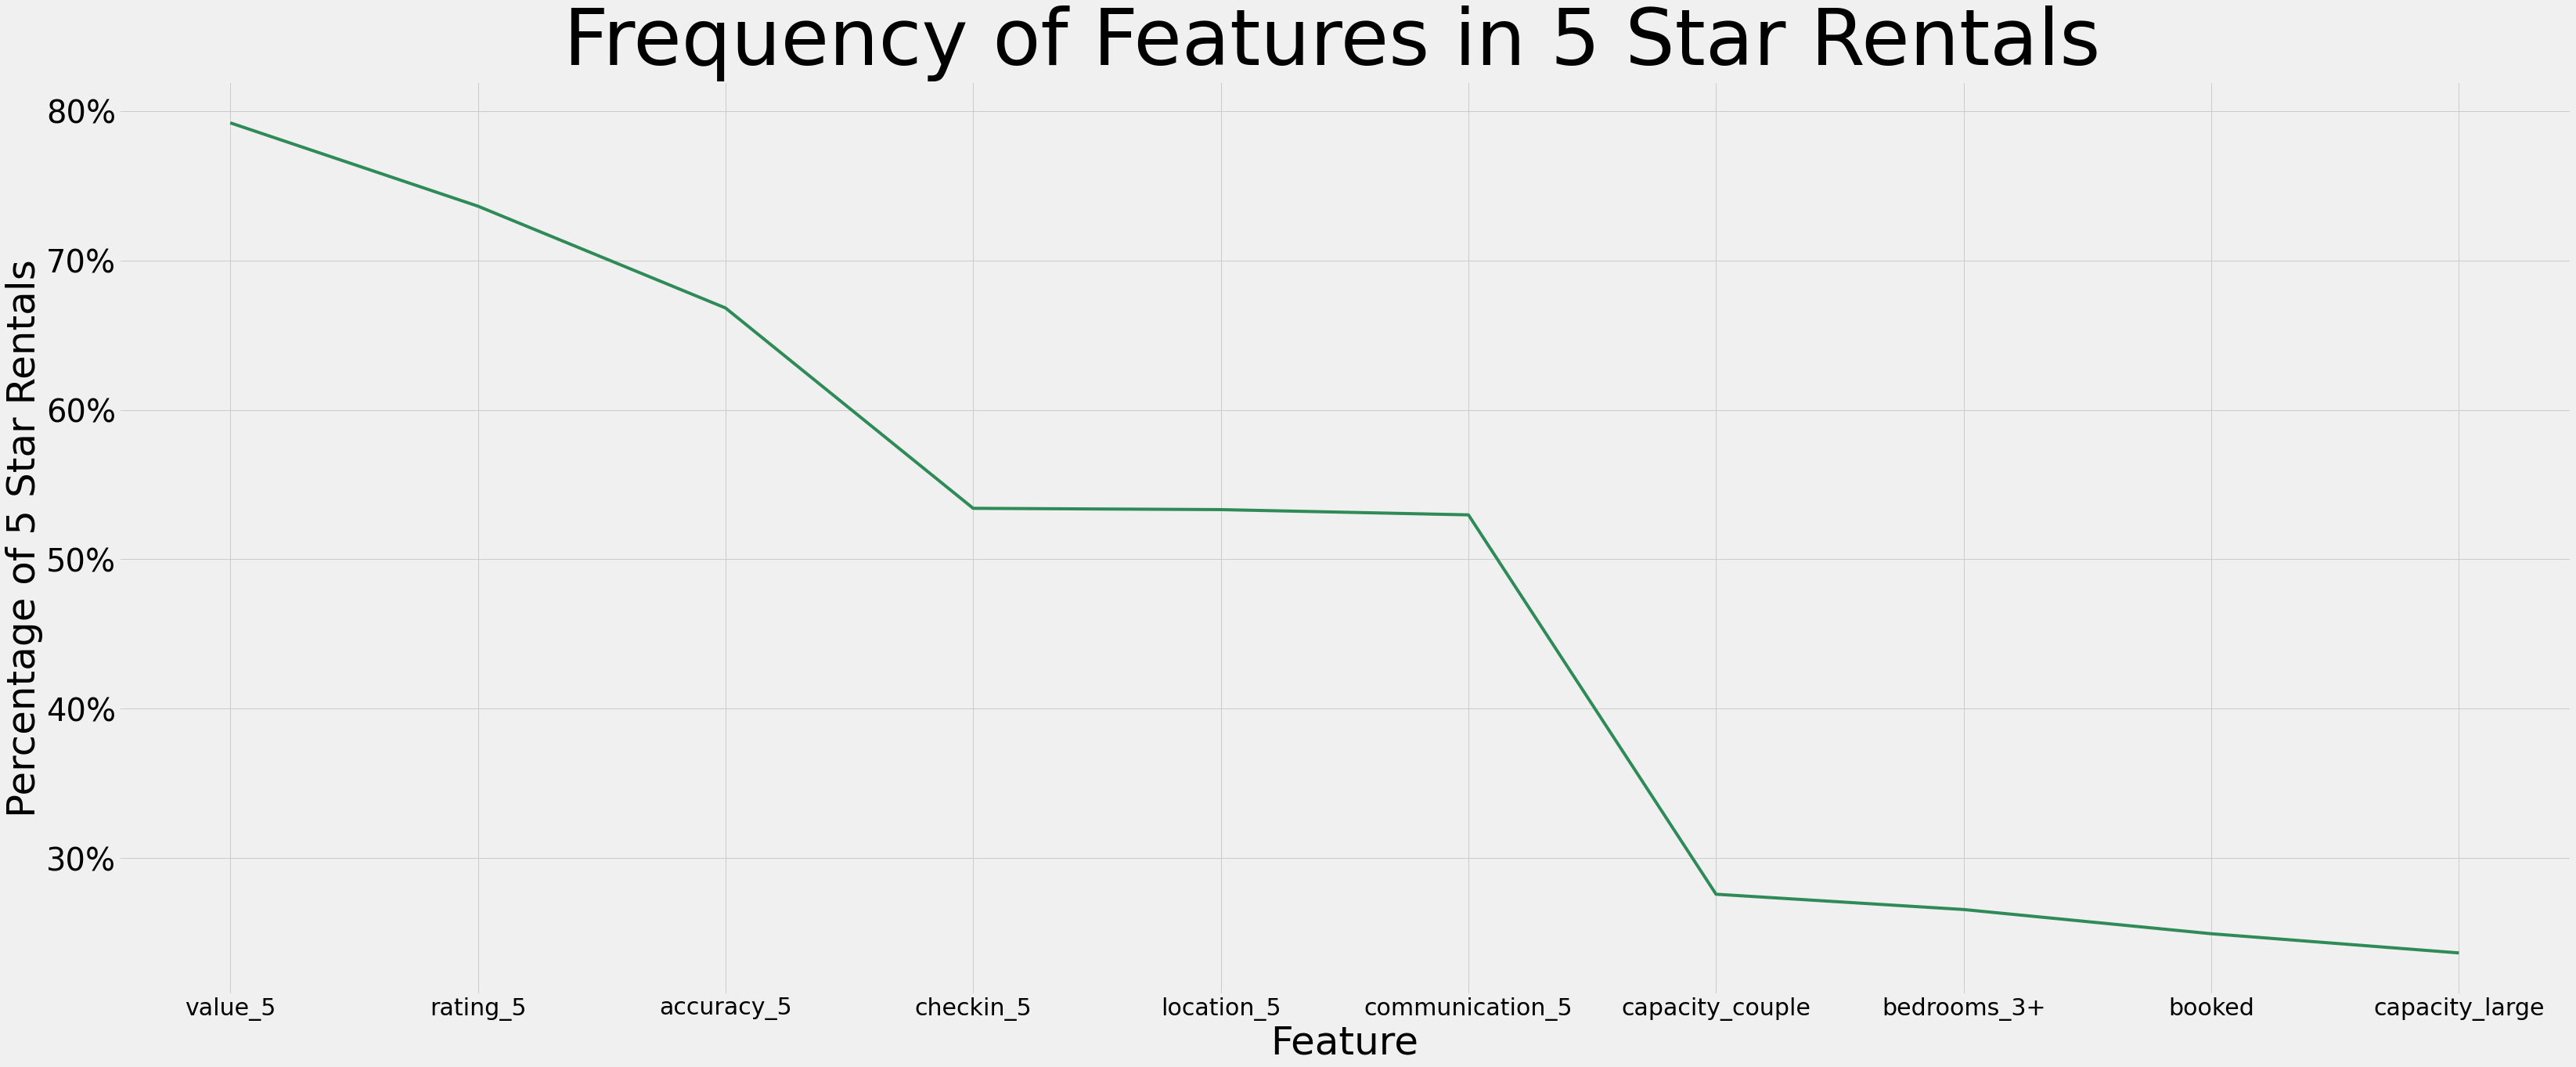

In [544]:
cleanliness_plot = plot_stats(cleanliness_stats)
cleanliness_plot

### Perfect Rating Stats

In [563]:
review_analysis_df = review_metrics.groupby('rating_5').sum()
review_analysis_df

,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost_True,host_listings_5+,instant_bookable_True,booked,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1-2,bedrooms_3+
rating_5,,,,,,,,,,,,,,,,
False,588,1248,553,1258,1058,197,3240,2604,3026,2077,1507,340,3618,4469,4564,1513
True,1416,1527,1276,1468,1318,1034,759,600,670,701,501,105,1035,1252,1187,546


In [546]:
rating_5_stats = get_stats(review_analysis_df)
rating_5_stats

rating_5,Metric,False,True,total,mean
5,value_5,197,1034,1231,0.839968
0,accuracy_5,588,1416,2004,0.706587
2,cleanliness_5,553,1276,1829,0.697649
4,location_5,1058,1318,2376,0.554714
1,communication_5,1248,1527,2775,0.550270
3,checkin_5,1258,1468,2726,0.538518
15,bedrooms_3+,1513,546,2059,0.265177
9,booked,2077,701,2778,0.252340
10,capacity_couple,1507,501,2008,0.249502
11,capacity_family,340,105,445,0.235955


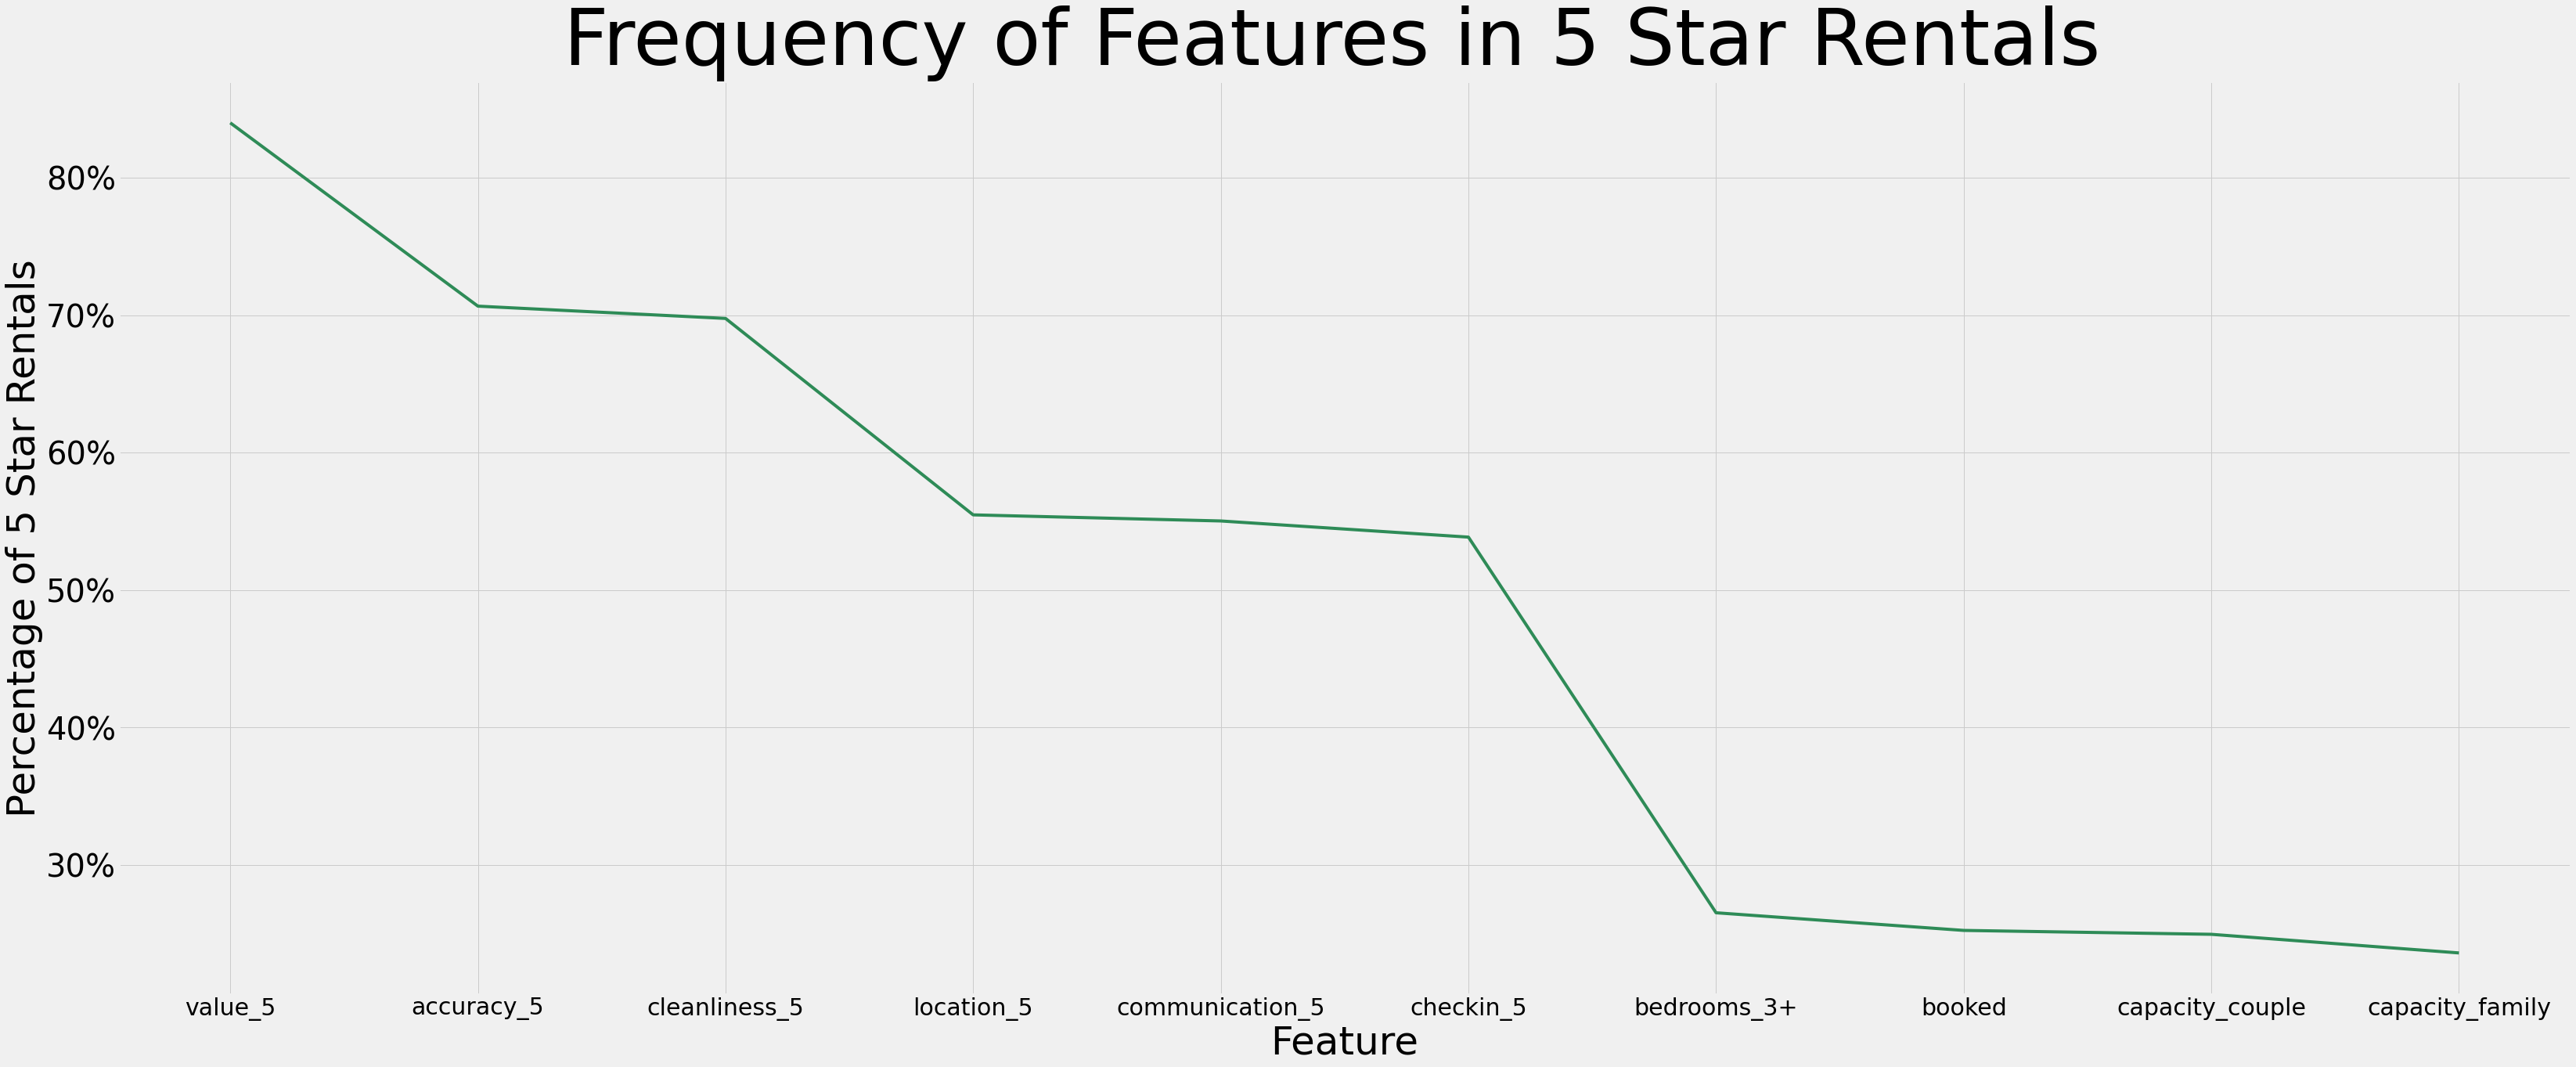

In [547]:
rating_5_plot = plot_stats(rating_5_stats)
rating_5_plot

### Instant Bookable Stats

In [553]:
instant_book_metrics = review_metrics.groupby('instant_bookable_True').sum()
instant_book_metrics

,rating_5,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost_True,host_listings_5+,booked,capacity_couple,capacity_family,capacity_large,host_response_100,bedrooms_1-2,bedrooms_3+
instant_bookable_True,,,,,,,,,,,,,,,,
False,1063,1193,1652,1077,1611,1323,736,2215,1172,1700,1325,264,2673,3136,3123,991
True,670,811,1123,752,1115,1053,495,1784,2032,1078,683,181,1980,2585,2628,1068


In [554]:
instant_book_stats = get_stats(instant_book_metrics)
instant_book_stats

instant_bookable_True,Metric,False,True,total,mean
8,host_listings_5+,1172,2032,3204,0.634207
15,bedrooms_3+,991,1068,2059,0.518698
14,bedrooms_1-2,3123,2628,5751,0.456964
13,host_response_100,3136,2585,5721,0.451844
7,superhost_True,2215,1784,3999,0.446112
5,location_5,1323,1053,2376,0.443182
12,capacity_large,2673,1980,4653,0.425532
3,cleanliness_5,1077,752,1829,0.411154
4,checkin_5,1611,1115,2726,0.409024
11,capacity_family,264,181,445,0.406742


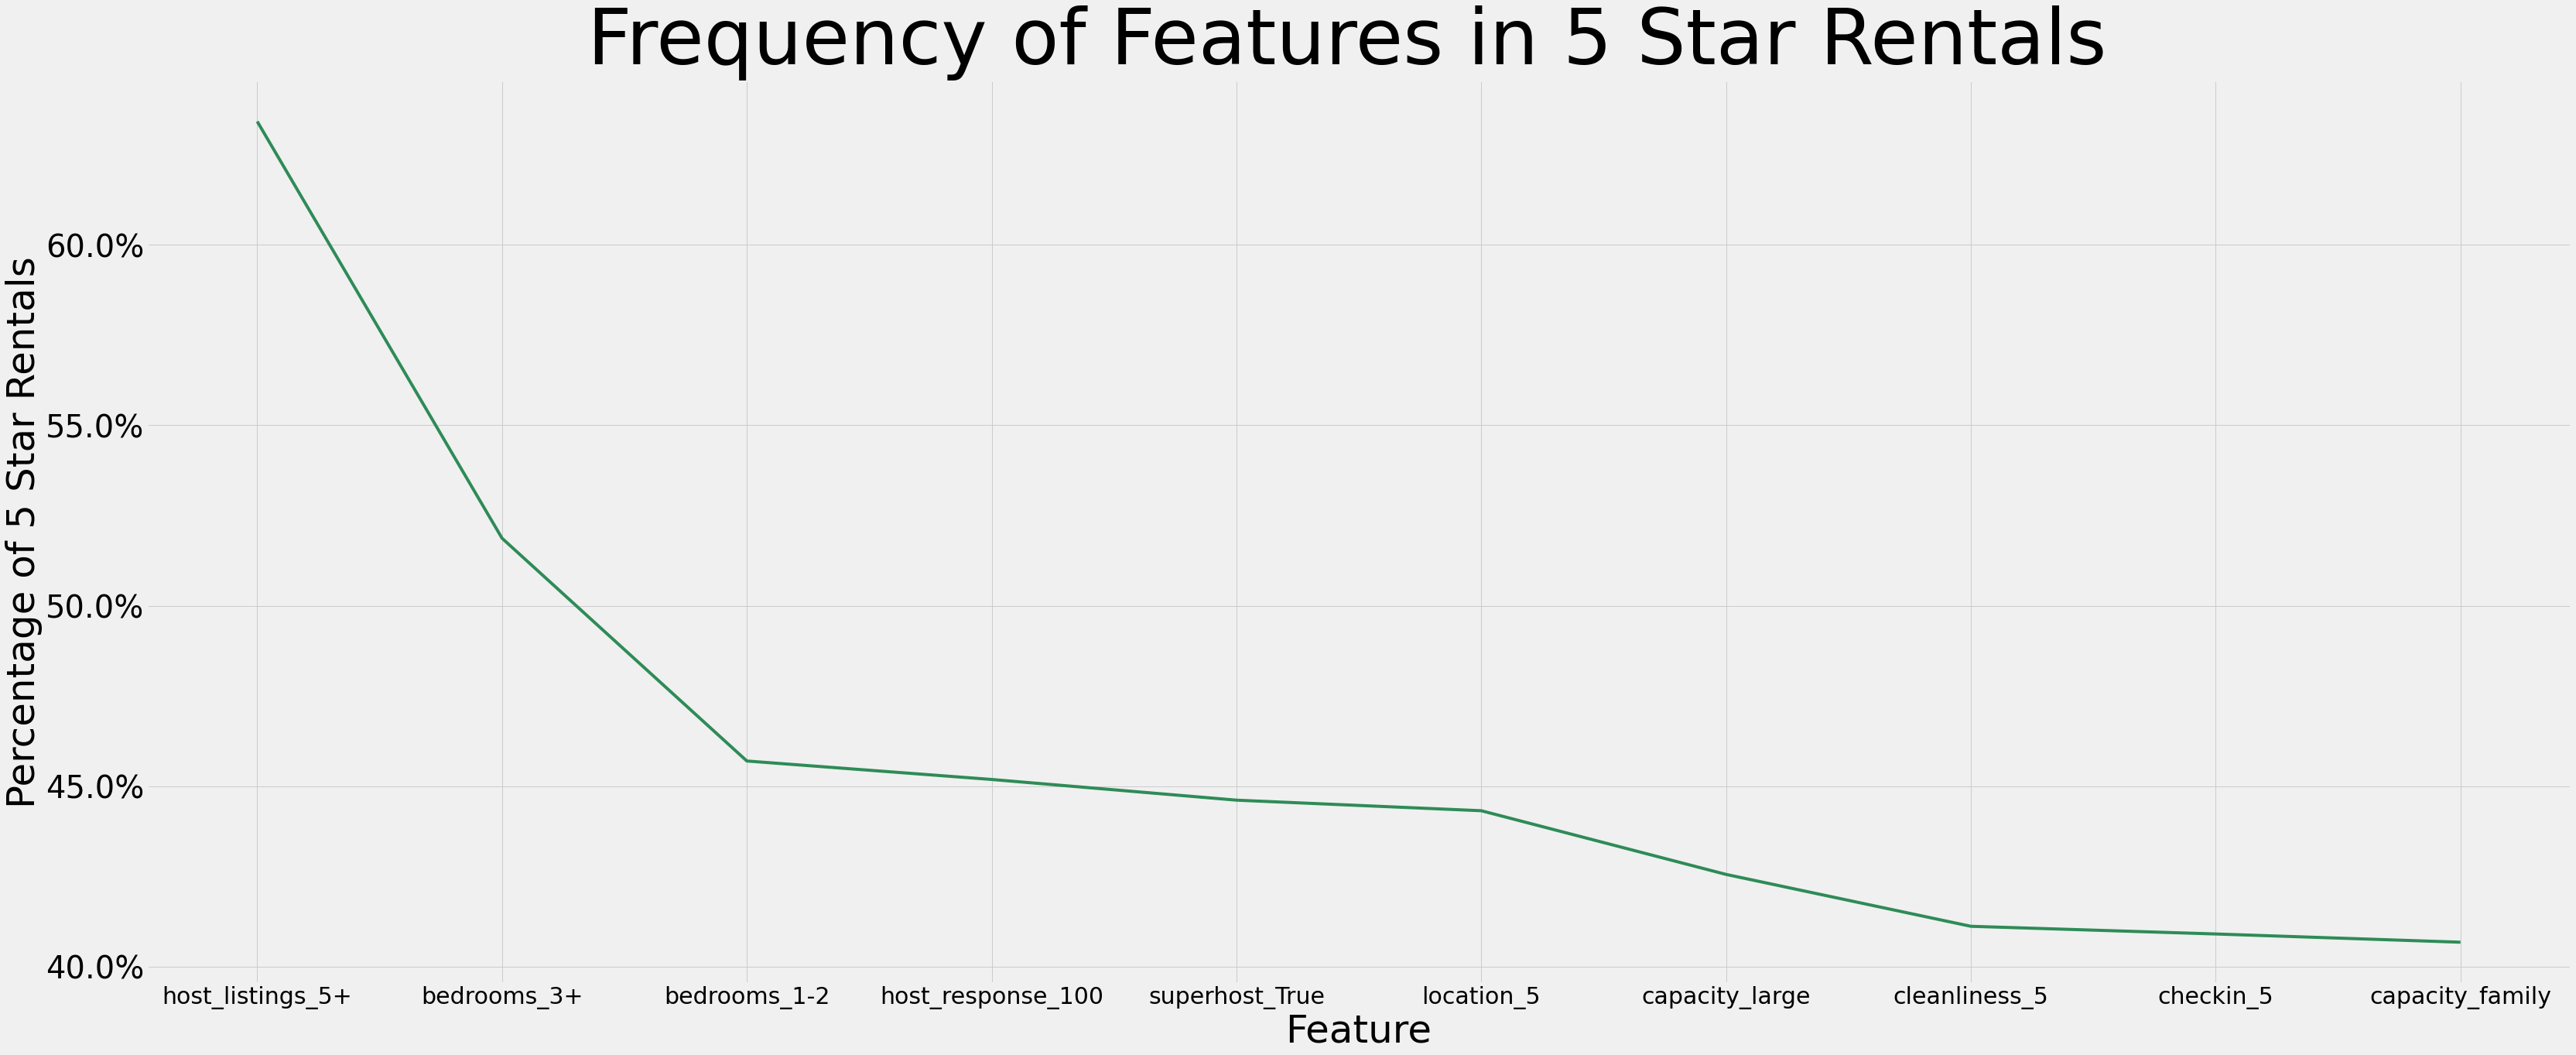

In [557]:
instant_book_plot = plot_stats(instant_book_stats)
instant_book_plot

## Attempting Master LinePlot

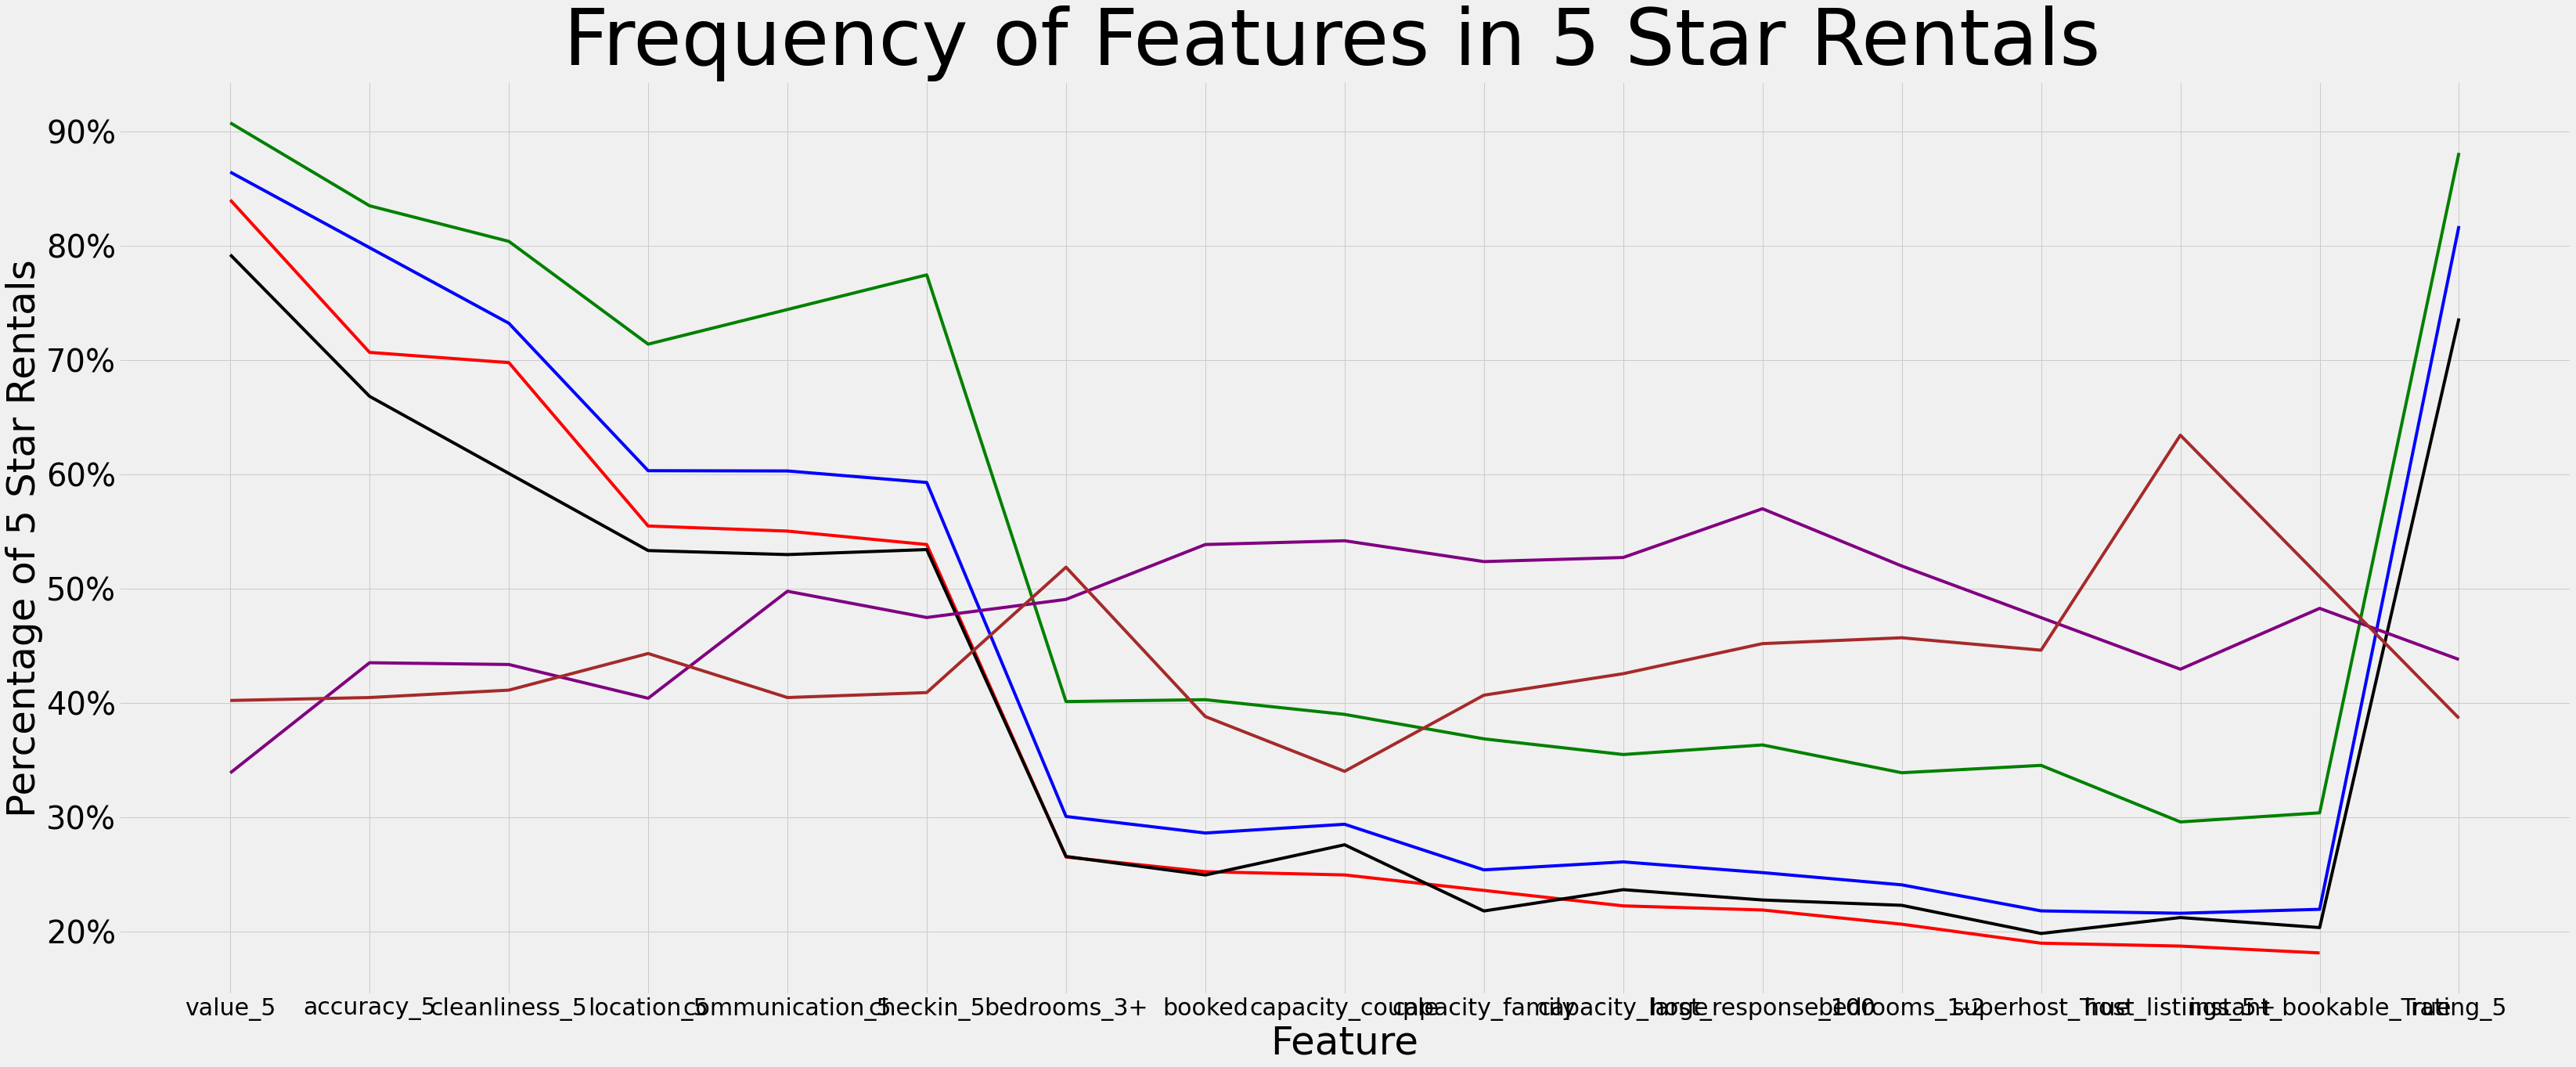

In [559]:
fig, ax = plt.subplots(figsize=(50,20))

p = sns.lineplot(data=rating_5_stats, x='Metric', y='mean', color ='red' );
p = sns.lineplot(data=communication_stats, x='Metric', y='mean', color ='green' );
p = sns.lineplot(data=accuracy_stats, x='Metric', y='mean', color ='blue' );
p = sns.lineplot(data=cleanliness_stats, x='Metric', y='mean', color ='black' );
p = sns.lineplot(data=superhost_stats, x='Metric', y='mean', color ='purple' );
p = sns.lineplot(data=instant_book_stats, x='Metric', y='mean', color ='brown' );




p.set_ylabel("Percentage of 5 Star Rentals", fontsize = 50)

p.set_xlabel("Feature", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

p.set_title("Frequency of Features in 5 Star Rentals ", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

### Analysis:
    - Even a small drop in accuracy results in a drop in the review score rating.

## Analysis of Review Metrics

In [ ]:
review_metrics

### Analysis:
- Units with a perfect accuracy rating were 72% more likely to have a perfect overall rating.
- Units with a perfect cleanliness rating were 64% more likely to have a perfect overall rating.
- Units with a perfect checkin rating were 63% more likely to have a perfect overall rating.
- Units with a perfect location rating were 58% more likely to have a perfect overall rating.
- Units with a perfect value rating were 56% more likely to have a perfect overall rating.


## Conclusion

## Further Work